# Phase 0: Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
import sys
sys.path.append('../')

import warning_utils
warning_utils.filter_end_user_warnings()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from art import utility as utils
from art.core import RecommendationEngine

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Phase 1: Data Preprocessing

## Take average of triplicate data

In [5]:
df4 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/17rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")
df5 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/18rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")
df6 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/19rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")

In [6]:
df_l = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/12strains_initial_design_seed1.csv")

In [7]:
df_l = df_l.iloc[:,[5,8]]

In [8]:
df_l

,Name*,Summary*
0,Strain 1,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_1_GPPS_0_I...
1,Strain 2,AtoB_0_HMGS_0_HMGR_2_MK_0_PMK_2_PMD_2_GPPS_1_I...
2,Strain 3,AtoB_2_HMGS_0_HMGR_0_MK_0_PMK_1_PMD_2_GPPS_1_I...
3,Strain 4,AtoB_0_HMGS_2_HMGR_2_MK_0_PMK_2_PMD_2_GPPS_0_I...
4,Strain 5,AtoB_2_HMGS_1_HMGR_2_MK_1_PMK_0_PMD_1_GPPS_2_I...
5,Strain 6,AtoB_1_HMGS_0_HMGR_1_MK_0_PMK_1_PMD_0_GPPS_2_I...
6,Strain 7,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
7,Strain 8,AtoB_0_HMGS_1_HMGR_1_MK_1_PMK_1_PMD_2_GPPS_2_I...
8,Strain 9,AtoB_1_HMGS_1_HMGR_1_MK_2_PMK_0_PMD_1_GPPS_0_I...
9,Strain 10,AtoB_1_HMGS_0_HMGR_2_MK_1_PMK_2_PMD_1_GPPS_2_I...


In [9]:
long_strings = df_l.iloc[:,-1].values.tolist()

In [10]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [11]:
df_t = pd.DataFrame(dict_list)

In [12]:
df = pd.concat([df_l.iloc[:,0],df_t], axis = 1)

In [13]:
# append the WT group to the dataframe
new_row = {' Name*': 'WT'}
for col in df.columns[1:]:
    new_row[col] = 1

In [14]:
df_wt = pd.DataFrame([new_row])

In [15]:
df = pd.concat([df_wt, df], ignore_index=True)

In [16]:
df4 = df4[df4['Time/hours'] == 24.0]
df5 = df5[df5['Time/hours'] == 24.0]
df6 = df6[df6['Time/hours'] == 24.0]

dfl = df4 + df5 + df6

dfl = dfl.iloc[:,-1]

dfl.index = np.linspace(0, 11, 12)

In [17]:
df = pd.concat([df, dfl / 3], axis = 1, ignore_index=True)

In [18]:
df.columns = ['Strain', 'AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi', 'Limonene Synthase', 'Limonene']

In [19]:
df

,Strain,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,WT,1,1,1,1,1,1,1,1,1,0.548045
1.0,Strain 1,2,2,0,2,0,1,0,2,0,0.425960
2.0,Strain 2,0,0,2,0,2,2,1,1,0,0.340830
3.0,Strain 3,2,0,0,0,1,2,1,1,0,0.333494
4.0,Strain 4,0,2,2,0,2,2,0,2,2,0.567516
5.0,Strain 5,2,1,2,1,0,1,2,0,1,0.343577
6.0,Strain 6,1,0,1,0,1,0,2,2,1,0.461772
7.0,Strain 7,2,2,0,2,0,0,1,1,2,0.662760
8.0,Strain 8,0,1,1,1,1,2,2,2,1,0.504226
9.0,Strain 9,1,1,1,2,0,1,0,0,1,0.536793


In [20]:
df['Limonene'].to_csv("../data/Original_Ob.csv", index = False)

## Transform the data to ART accepted format

In [21]:
df = pd.melt(df, id_vars=['Strain'], 
                    value_vars=['AtoB', 'HMGS', 'HMGR', 'MK','PMK','PMD','GPPS','Idi','Limonene Synthase','Limonene'],
                    var_name='Measurement Type', value_name='Value')

In [22]:
df

,Strain,Measurement Type,Value
0,WT,AtoB,1
1,Strain 1,AtoB,2
2,Strain 2,AtoB,0
3,Strain 3,AtoB,2
4,Strain 4,AtoB,0
...,...,...,...
115,Strain 7,Limonene,0.66276
116,Strain 8,Limonene,0.504226
117,Strain 9,Limonene,0.536793
118,Strain 10,Limonene,0.336665


In [23]:
df.to_csv("../data/Level_data.csv", index = False)

# Phase 2: Learning-Recommendation Cycles

## Cycle1

### Defining parameters

In [24]:
"""
Defining all the required parameters. 
Attention to input_var_type paramter, our case is about categorical variables.

Trying different alpha from 0 to 1 to get different recommendations.

Finally, take 3 recommendations from alpha = 0 and another 3 from alpha = 1.

"""



user_params = {
    'data_file': '../data/Level_data.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD',
                   'GPPS', 'Idi', 'Limonene Synthase'],  # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 6,  # Number of recommendations to be provided
    'n_instances_cycle1': 12,
    'max_mcmc_cores': 2,
    'cross_val': True,
    'output_dir': '../results/Level_result',                          # Directory to store output files
    'verbose': 1                                                  # Amount of information to be displayed
}

In [25]:
cycle = 1

In [26]:
df = utils.load_study(data_file=user_params['data_file'])

In [27]:
df.columns = ['Line Name', 'Measurement Type', 'Value']

In [28]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'] + "_alpha = 0",
    'last_dashes_denote_replicates': False,
    'cross_val_partitions': 12,
    'input_var_type': 'categorical',
}

### alpha = 0

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 12 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Done fitting L0 models in 26.01 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.94 s
Fitting L0 models…
Building TPOT models…
Best pipeline: GradientBoostingRegressor(ZeroCount(input_matrix), alpha=0.8, learning_rate=1.0, loss=huber, max_depth=4, max_features=0.35000000000000003, min_samples_leaf=8, min_samples_split=16, n_estimators=100, subsample=0.4)
Done fitting L0 models in 68.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.85 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=4, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)
Done fitting L0 models in 24.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.81 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(StandardScaler(RandomForestRegressor(RidgeCV(MinMaxScaler(input_matrix)), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=3, n_estimators=100)))
Done fitting L0 models in 50.34 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.12 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=5, min_samples_split=3, n_estimators=100)), learning_rate=0.1, loss=linear, n_estimators=100)
Done fitting L0 models in 22.84 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.25 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=2, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)
Done fitting L0 models in 17.75 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 17.30 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(RobustScaler(MinMaxScaler(input_matrix)), l1_ratio=1.0, tol=0.1)
Done fitting L0 models in 35.57 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 20.49 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(LinearSVR(SelectFromModel(input_matrix, max_features=0.2, n_estimators=100, threshold=0.1), C=15.0, dual=False, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.0001), C=15.0, dual=True, epsilon=0.1, loss=epsilon_insensitive, tol=0.01)
Done fitting L0 models in 16.45 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.94 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=1.0, max_depth=10, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.45, verbosity=0)
Done fitting L0 models in 23.37 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.28 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Done fitting L0 models in 20.78 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.21 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=1.0, max_depth=9, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9500000000000001, verbosity=0)
Done fitting L0 models in 28.61 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 17.28 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(LinearSVR(RobustScaler(input_matrix), C=25.0, dual=False, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.0001))
Done fitting L0 models in 24.07 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 17.22 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.195356,40.291229,0.145539,0.059346,-4.186239
Random Forest Regressor,0.102095,23.804763,0.059014,0.013906,-0.215256
Support Vector Regressor,0.098071,23.157700,0.051792,0.012300,-0.074924
Kernel Ridge Regressor,0.219107,46.829977,0.123445,0.063246,-4.527139
K-NN Regressor,0.105761,24.466621,0.044354,0.013153,-0.149410
Gaussian Process Regressor,0.110645,25.798191,0.050039,0.014746,-0.288675
Gradient Boosting Regressor,0.097776,23.298058,0.058548,0.012988,-0.135031
TPOT Regressor,0.117818,27.740166,0.078790,0.020089,-0.755590
Ensemble Model,0.108383,24.114300,0.057828,0.015091,-0.318798


Done with 12-fold cross-validation in 598.60 s


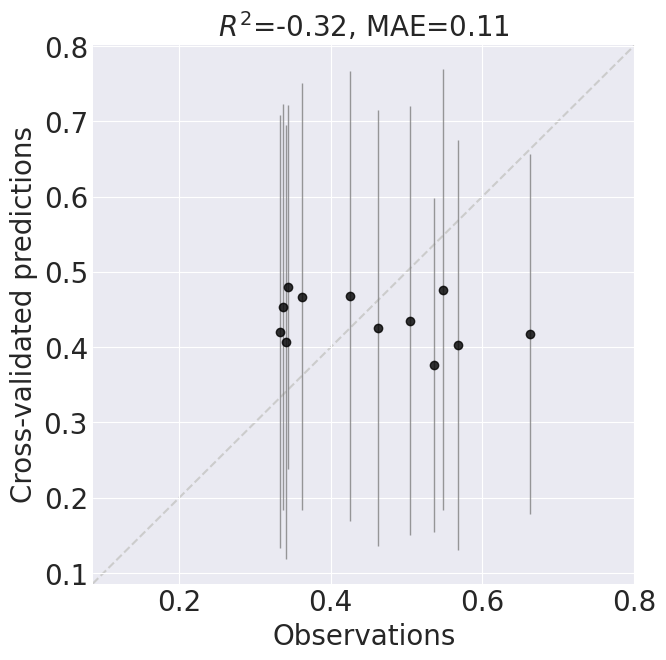

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.001, max_depth=10, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 19.71 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 20.64 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.070238e-02,1.865360e+01,4.846008e-02,8.861253e-03,0.225611
Random Forest Regressor,3.784429e-02,9.105925e+00,2.211553e-02,1.921287e-03,0.832098
Support Vector Regressor,7.974124e-02,1.914501e+01,3.007762e-02,7.263329e-03,0.365254
Kernel Ridge Regressor,7.793630e-02,1.653876e+01,4.228872e-02,7.862403e-03,0.312901
K-NN Regressor,7.807591e-02,1.813896e+01,3.673697e-02,7.445452e-03,0.349338
Gaussian Process Regressor,2.817275e-09,6.538989e-07,1.495832e-09,1.017455e-17,1.000000
Gradient Boosting Regressor,1.032684e-05,2.277616e-03,1.356757e-05,2.907225e-10,1.000000
TPOT Regressor,1.012883e-01,2.562723e+01,5.910839e-02,1.375312e-02,-0.201892
Ensemble Model,4.985431e-02,1.180067e+01,2.322958e-02,3.025066e-03,0.735638


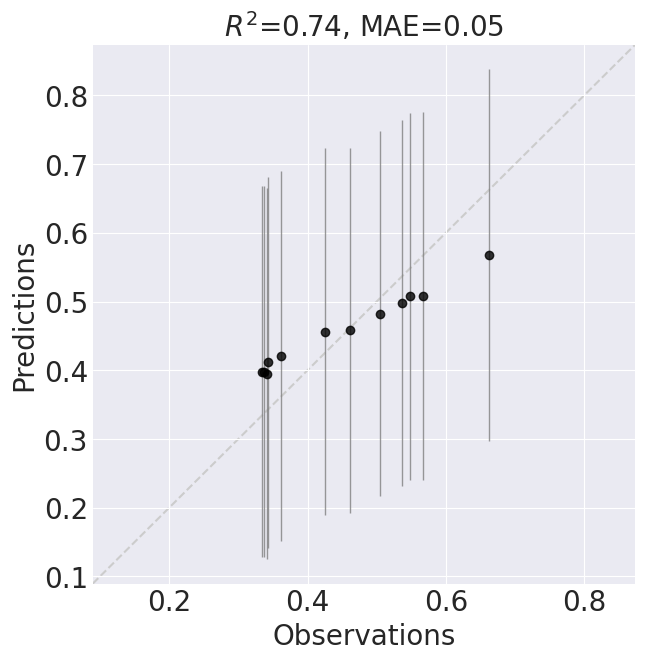

Done building models in 42.01 s
Finding all possible categorical designs…
Done finding categorical designs in 1001.51 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.01 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,2.0,2.0,0.549435
1,2.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.548289
2,1.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.545586
3,2.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,2.0,0.543902
4,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.543888
5,2.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,2.0,0.543305


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 2.68 s


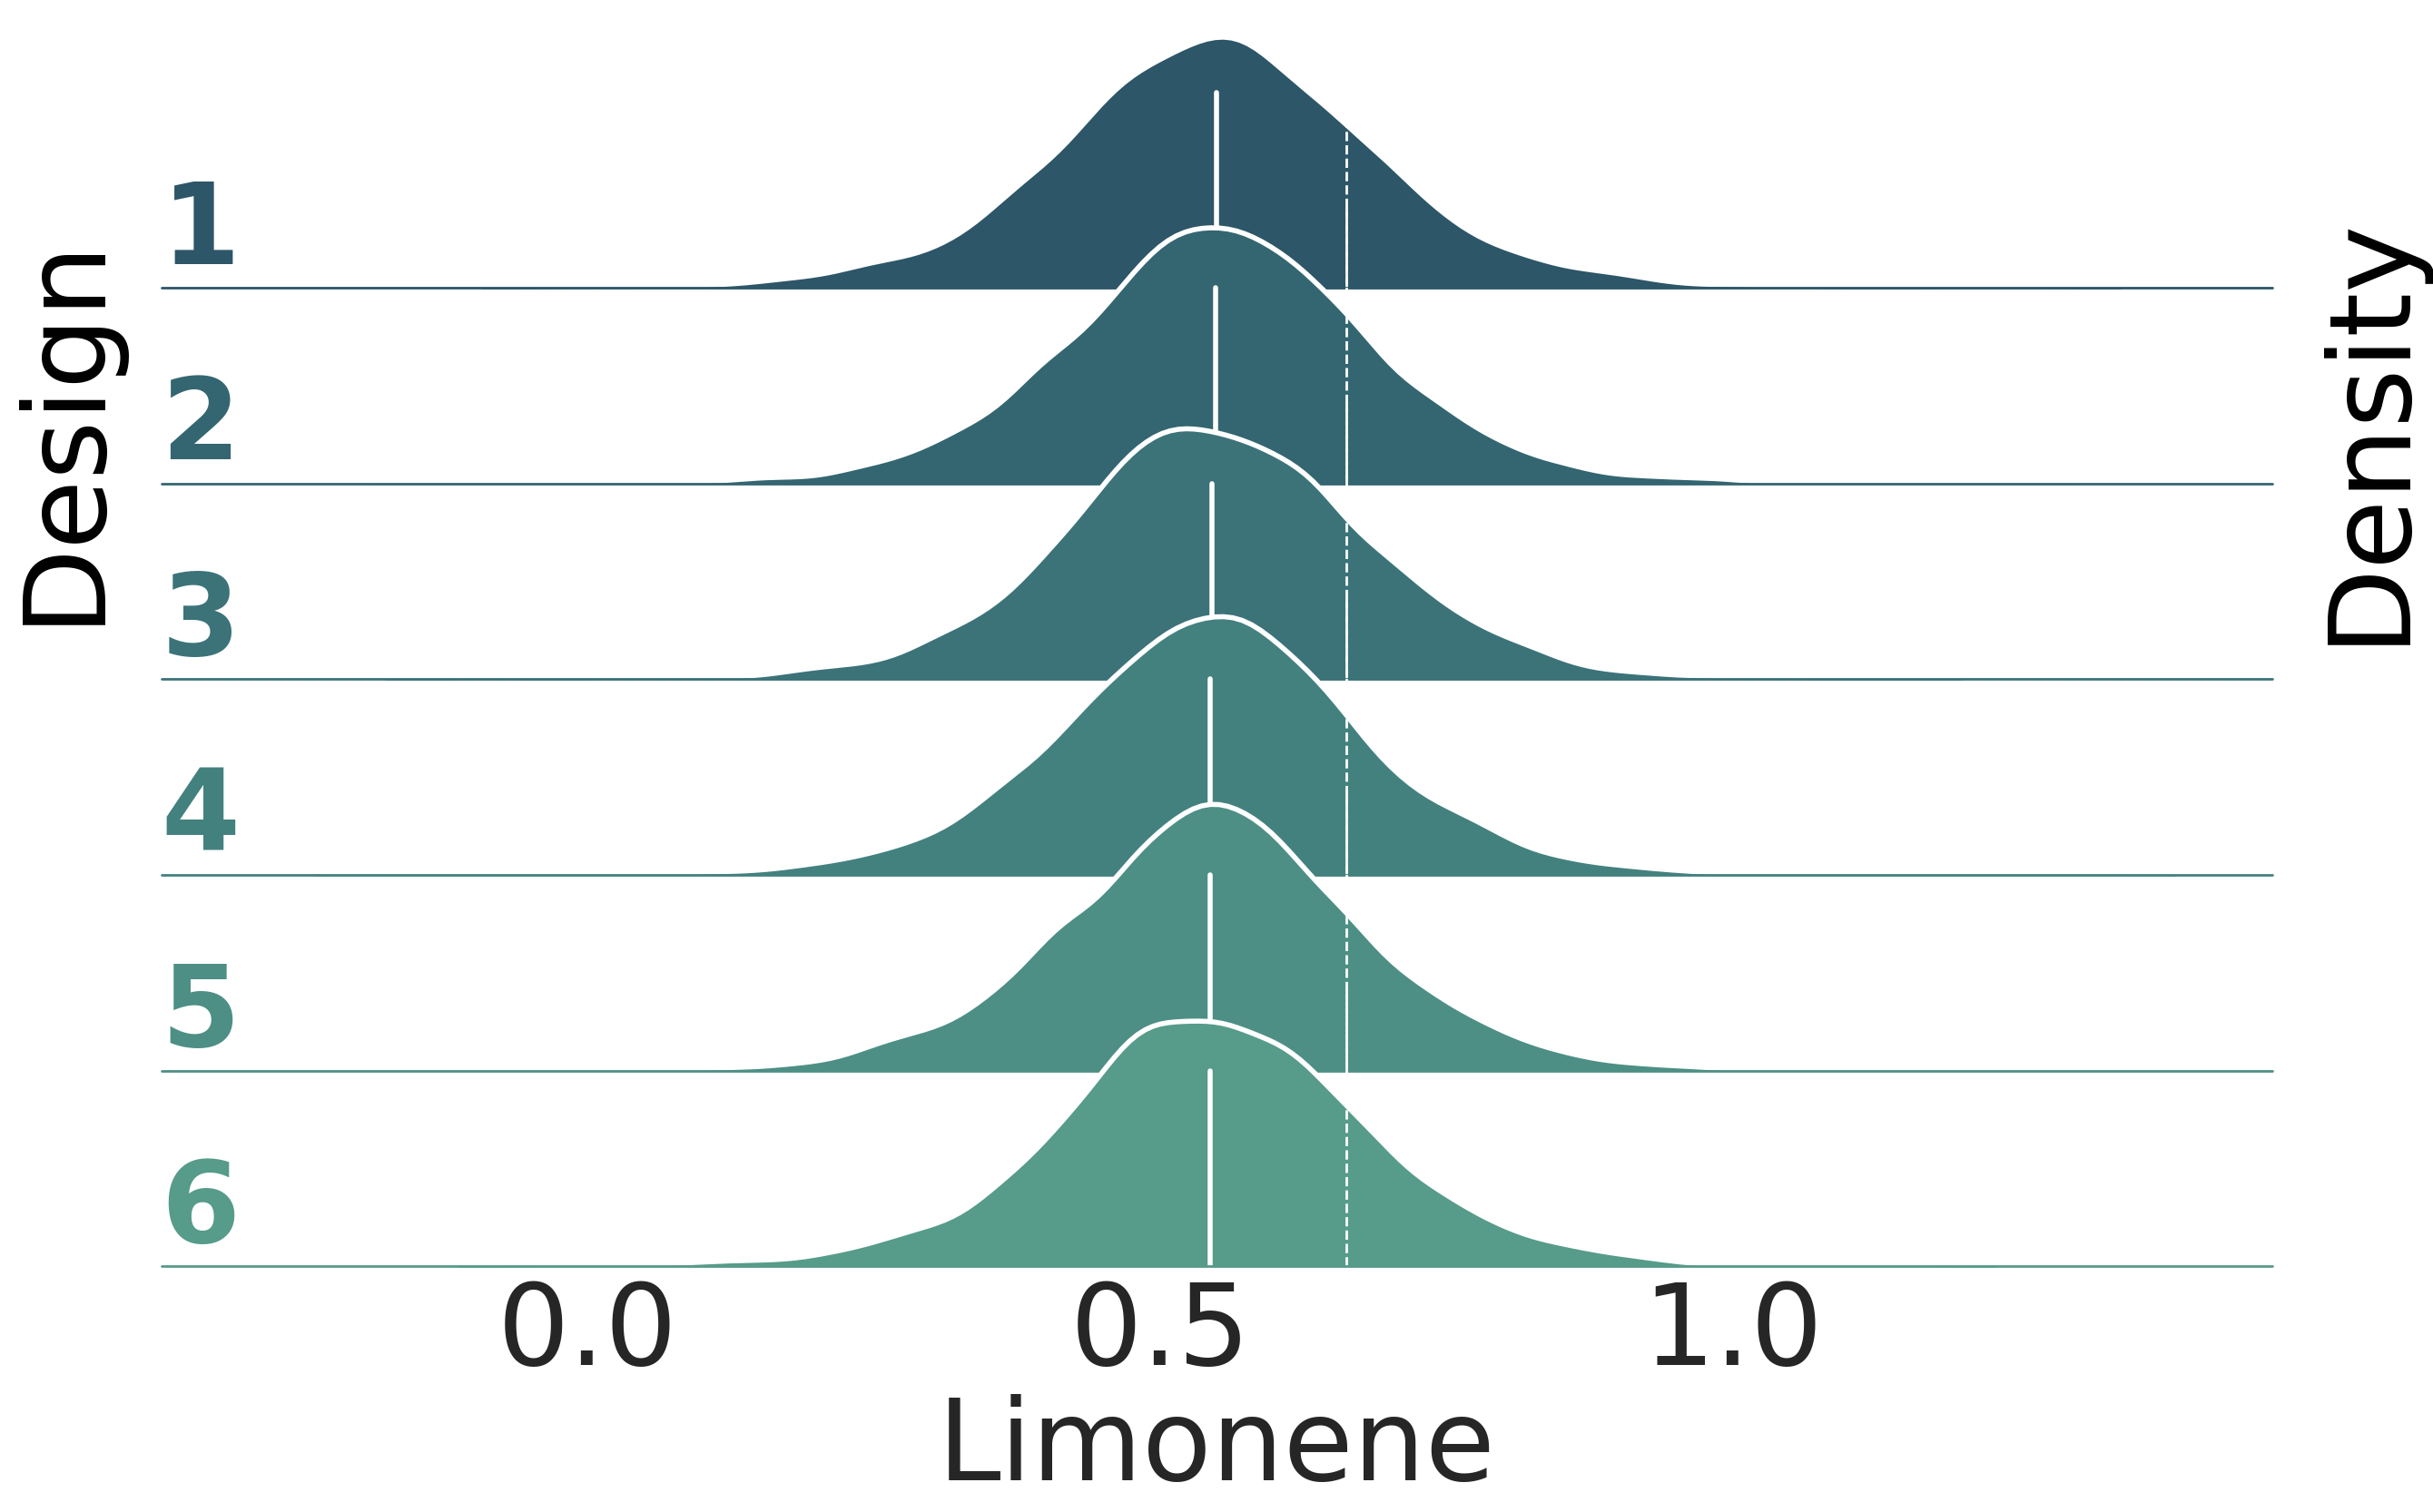

Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.10 s
Done computing success probabilities in 1.10 s


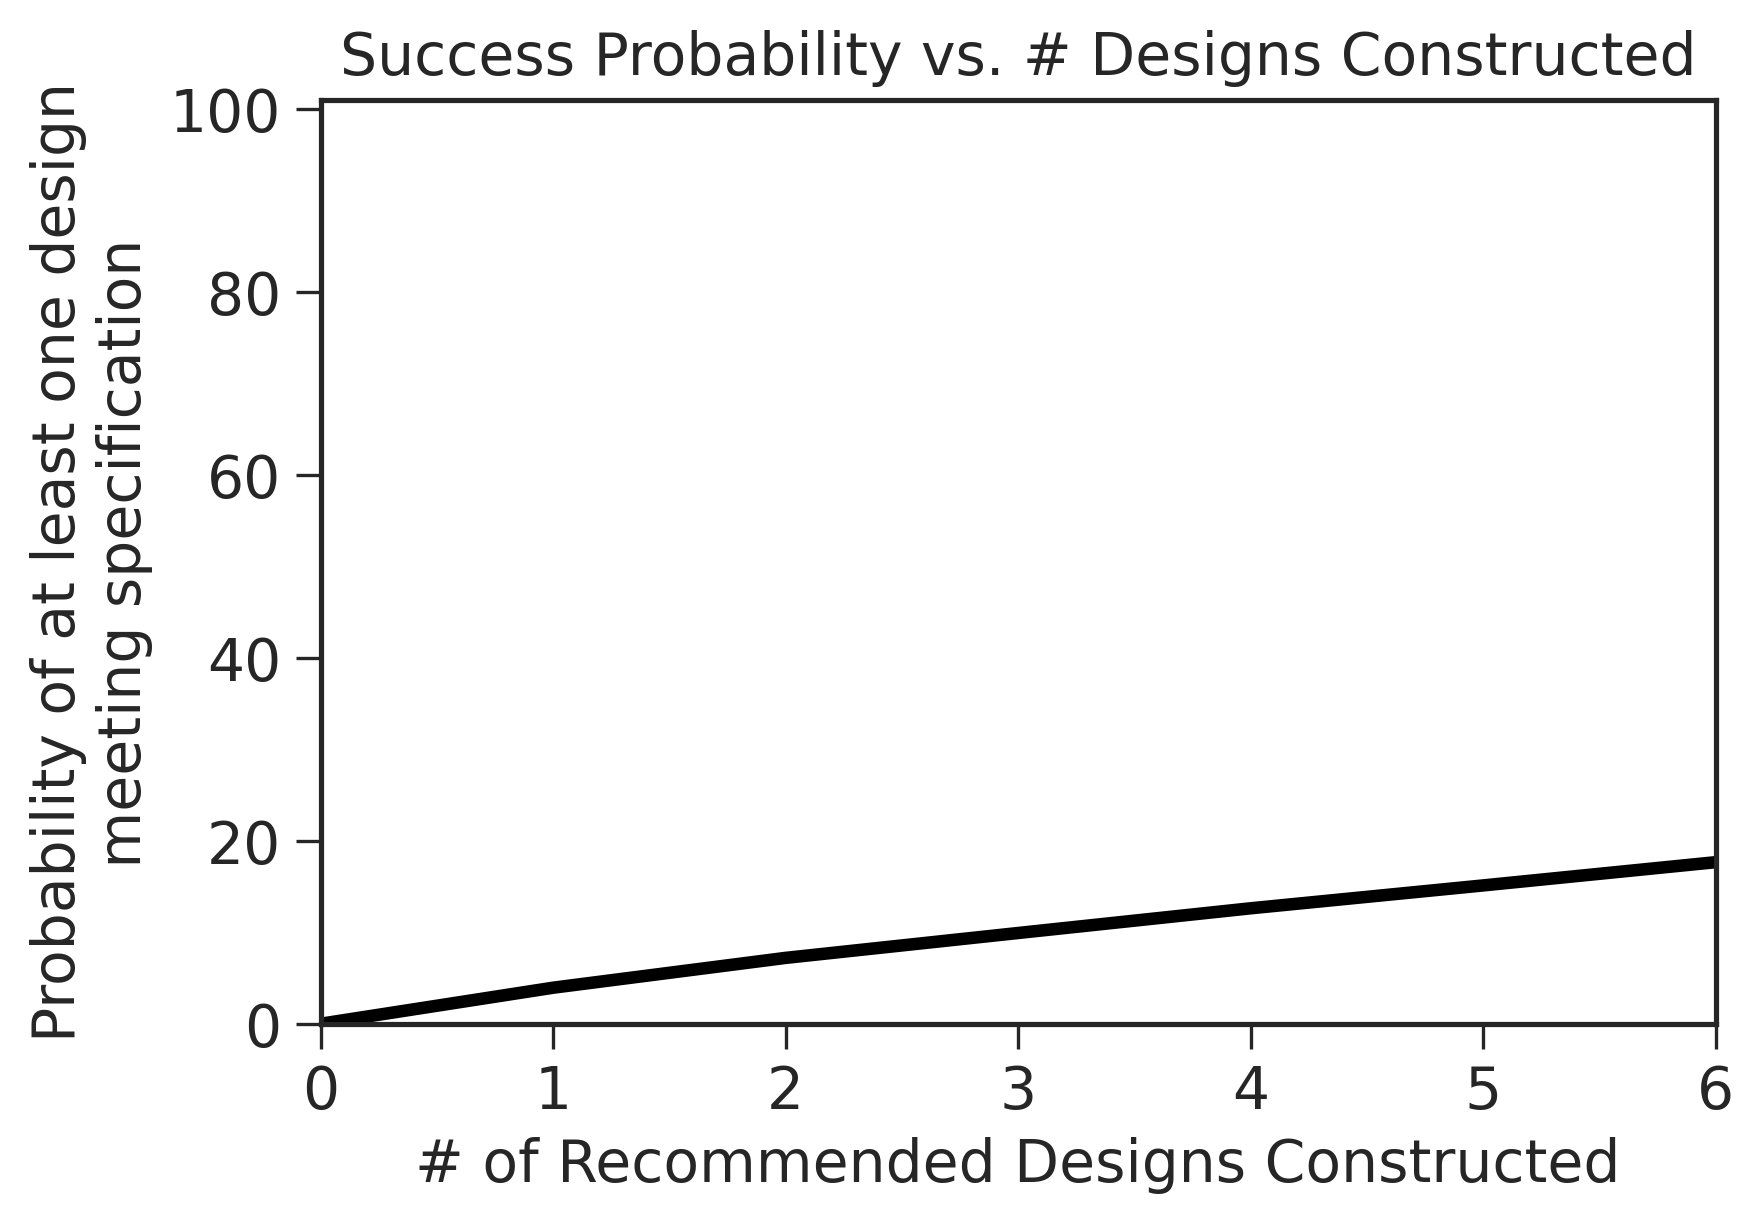

CPU times: user 8min 45s, sys: 10 s, total: 8min 55s
Wall time: 27min 29s


In [29]:
%%time
art = RecommendationEngine(df=df, alpha = 0, **art_params)

### alpha = 1.0

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 12 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Done fitting L0 models in 24.61 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.05 s
Fitting L0 models…
Building TPOT models…
Best pipeline: GradientBoostingRegressor(ZeroCount(input_matrix), alpha=0.8, learning_rate=1.0, loss=huber, max_depth=4, max_features=0.35000000000000003, min_samples_leaf=8, min_samples_split=16, n_estimators=100, subsample=0.4)
Done fitting L0 models in 67.69 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.73 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=4, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)
Done fitting L0 models in 23.35 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.68 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(StandardScaler(RandomForestRegressor(RidgeCV(MinMaxScaler(input_matrix)), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=3, n_estimators=100)))
Done fitting L0 models in 50.10 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.90 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=5, min_samples_split=3, n_estimators=100)), learning_rate=0.1, loss=linear, n_estimators=100)
Done fitting L0 models in 17.56 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.57 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=2, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)
Done fitting L0 models in 16.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.53 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(RobustScaler(MinMaxScaler(input_matrix)), l1_ratio=1.0, tol=0.1)
Done fitting L0 models in 34.71 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 16.16 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(LinearSVR(SelectFromModel(input_matrix, max_features=0.2, n_estimators=100, threshold=0.1), C=15.0, dual=False, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.0001), C=15.0, dual=True, epsilon=0.1, loss=epsilon_insensitive, tol=0.01)
Done fitting L0 models in 15.35 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 26.82 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=1.0, max_depth=10, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.45, verbosity=0)
Done fitting L0 models in 22.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 16.61 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Done fitting L0 models in 20.23 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 16.47 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=1.0, max_depth=9, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9500000000000001, verbosity=0)
Done fitting L0 models in 26.24 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 17.91 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(LinearSVR(RobustScaler(input_matrix), C=25.0, dual=False, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.0001))
Done fitting L0 models in 23.59 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 17.28 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.195356,40.291229,0.145539,0.059346,-4.186239
Random Forest Regressor,0.102095,23.804763,0.059014,0.013906,-0.215256
Support Vector Regressor,0.098071,23.157700,0.051792,0.012300,-0.074924
Kernel Ridge Regressor,0.219107,46.829977,0.123445,0.063246,-4.527139
K-NN Regressor,0.105761,24.466621,0.044354,0.013153,-0.149410
Gaussian Process Regressor,0.110645,25.798191,0.050039,0.014746,-0.288675
Gradient Boosting Regressor,0.097776,23.298058,0.058548,0.012988,-0.135031
TPOT Regressor,0.117818,27.740166,0.078790,0.020089,-0.755590
Ensemble Model,0.108383,24.114300,0.057828,0.015091,-0.318798


Done with 12-fold cross-validation in 566.26 s


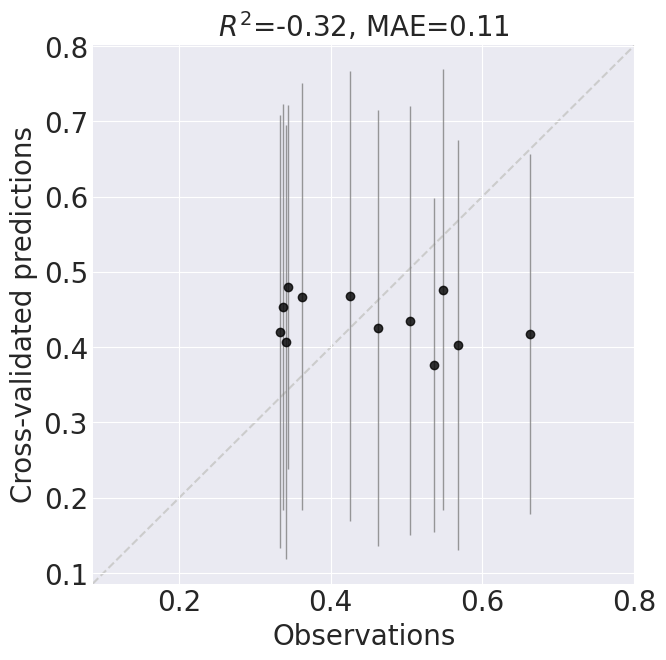

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.001, max_depth=10, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 20.02 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 18.00 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.070238e-02,1.865360e+01,4.846008e-02,8.861253e-03,0.225611
Random Forest Regressor,3.784429e-02,9.105925e+00,2.211553e-02,1.921287e-03,0.832098
Support Vector Regressor,7.974124e-02,1.914501e+01,3.007762e-02,7.263329e-03,0.365254
Kernel Ridge Regressor,7.793630e-02,1.653876e+01,4.228872e-02,7.862403e-03,0.312901
K-NN Regressor,7.807591e-02,1.813896e+01,3.673697e-02,7.445452e-03,0.349338
Gaussian Process Regressor,2.817275e-09,6.538989e-07,1.495832e-09,1.017455e-17,1.000000
Gradient Boosting Regressor,1.032684e-05,2.277616e-03,1.356757e-05,2.907225e-10,1.000000
TPOT Regressor,1.012883e-01,2.562723e+01,5.910839e-02,1.375312e-02,-0.201892
Ensemble Model,4.985431e-02,1.180067e+01,2.322958e-02,3.025066e-03,0.735638


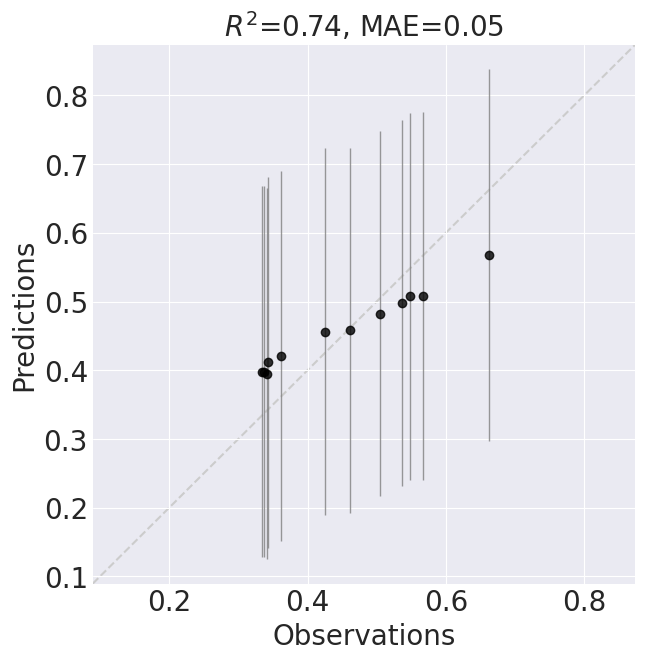

Done building models in 39.24 s
Finding all possible categorical designs…
Done finding categorical designs in 90.06 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.01 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.441341
1,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,0.459868
2,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.460737
3,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.450632
4,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.467420
5,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.471085


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.81 s


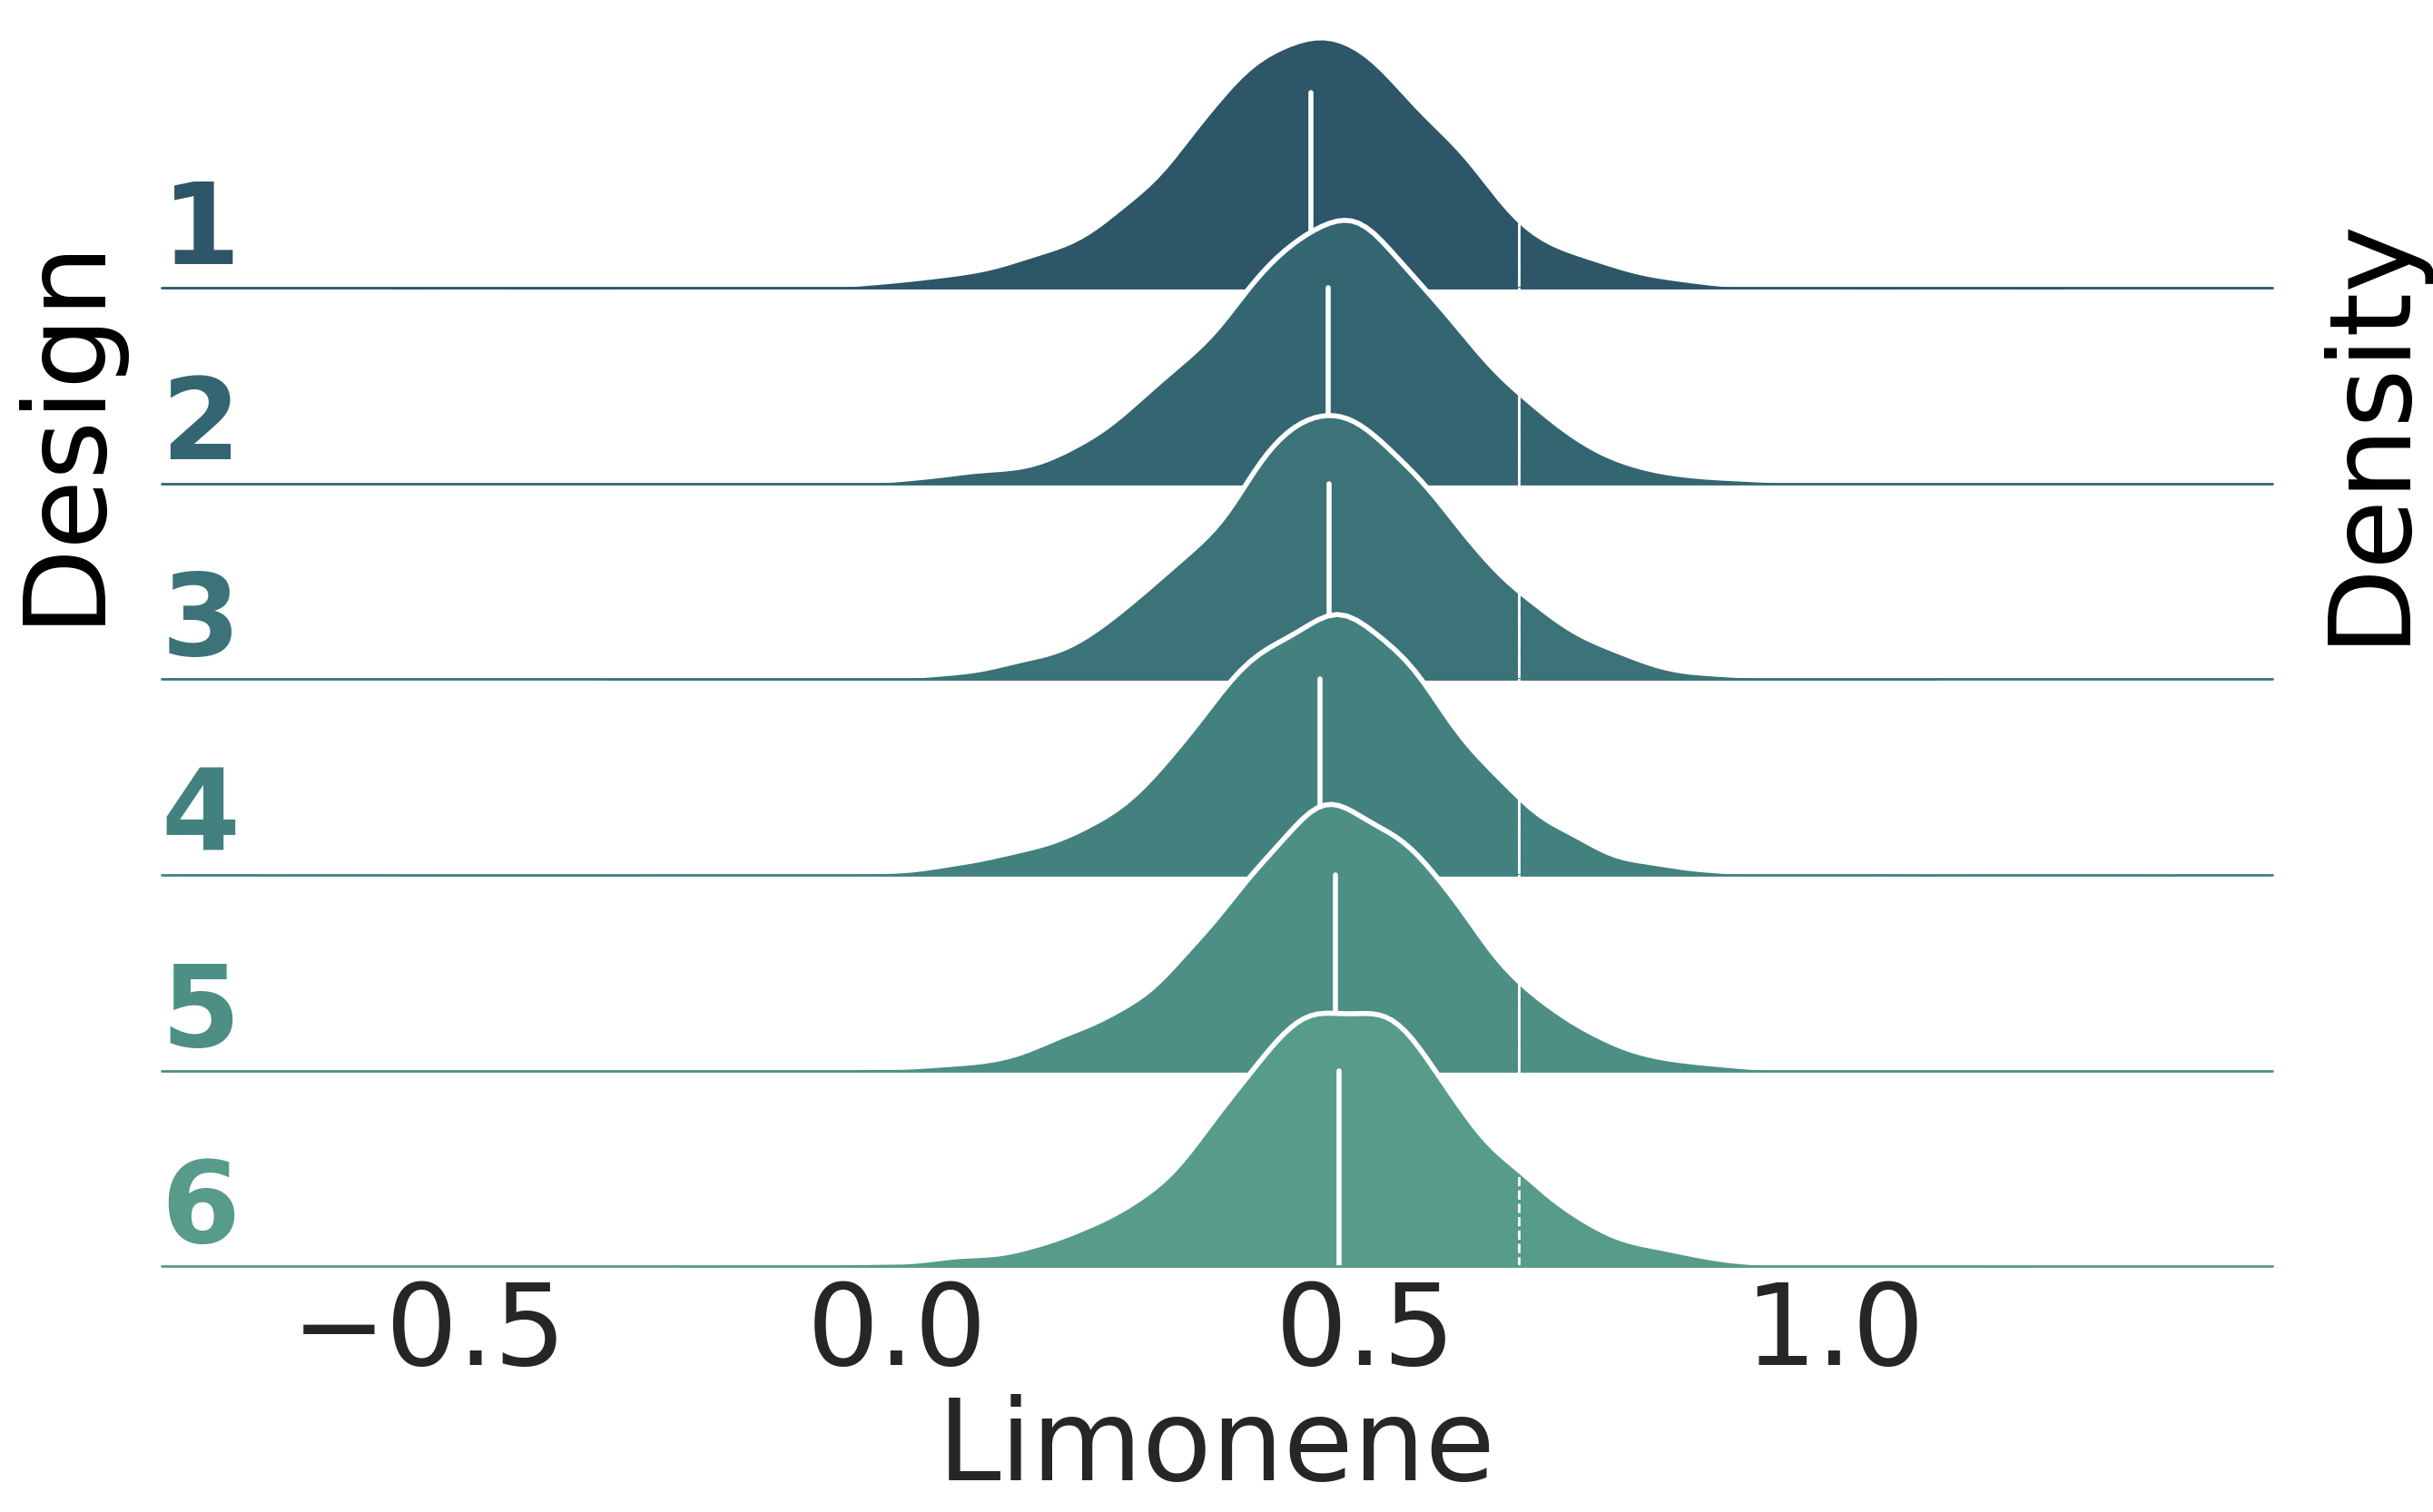

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.86 s
Done computing success probabilities in 0.86 s


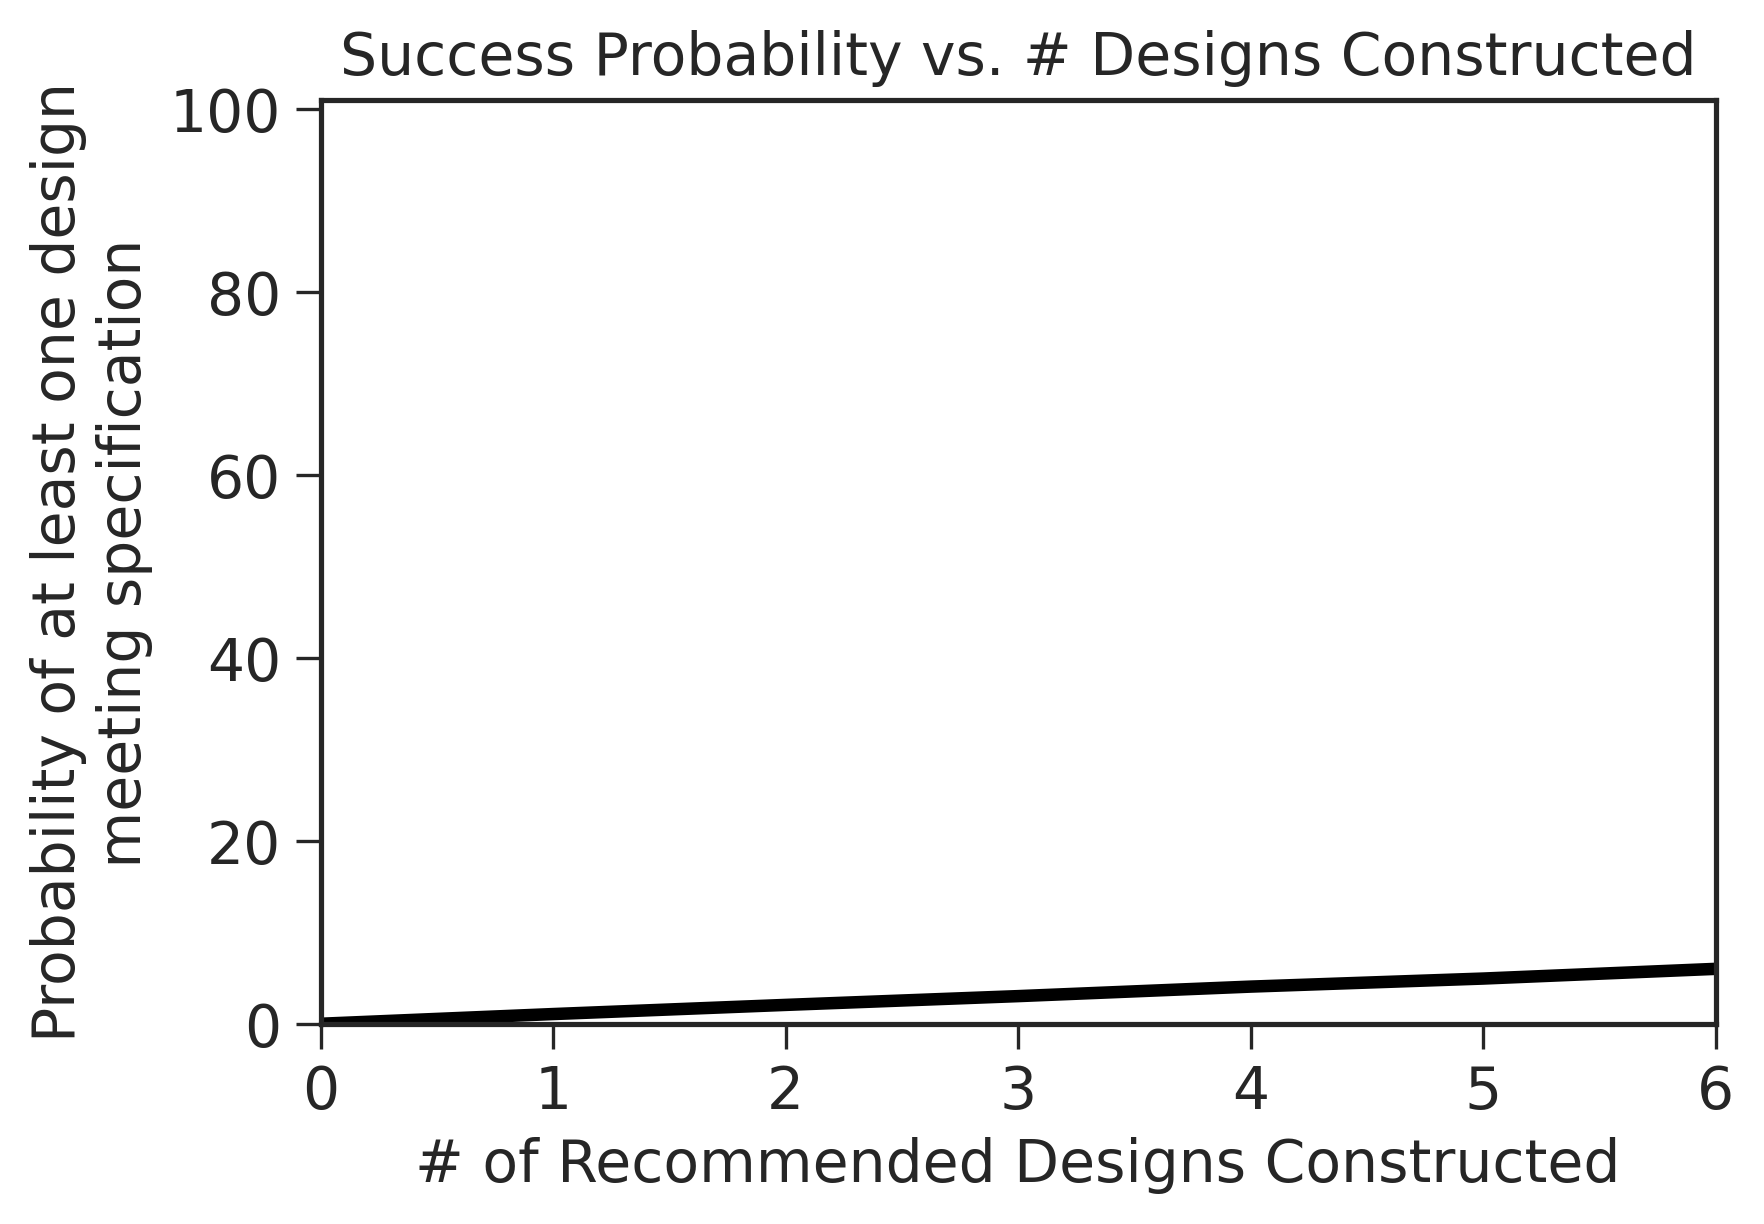

CPU times: user 8min 26s, sys: 9.27 s, total: 8min 35s
Wall time: 11min 40s


In [30]:
%%time
art = RecommendationEngine(df=df, alpha = 1, **art_params)

## Cycle 2

### Importing new 'experiement' data

In [31]:
"""
After Cycle 1, we got 3 recommendations enzynmes' combinations when alpha = 0 and 3 when alpha = 1. Using these
recommendations enzynmes' combinations to do silicon 'experiment' to get new sythetic data, which is the newly 
importing data. Using these 6 newly generated data to train the model again, which we called 'Cycle 2'.
"""

df1 = pd.read_csv("../data/Cycle 1/17rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")
df2 = pd.read_csv("../data/Cycle 1/18rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")
df3 = pd.read_csv("../data/Cycle 1/19rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")

In [32]:
df1 = df1[df1['Time/hours'] == 24.0]
df2 = df2[df2['Time/hours'] == 24.0]
df3 = df3[df3['Time/hours'] == 24.0]

In [33]:
df = df1 + df2 + df3

In [34]:
df = df.iloc[1:,:]

In [35]:
df

,Strain,Time/hours,Acetyl-CoA,Acetoacetyl-CoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
193,Recommendation Strain 1Recommendation Strain 1...,72.0,0.391459,0.118678,0.108838,0.016406,0.108842,0.064453,0.009199,0.006146,0.115114,1.995933
290,Recommendation Strain 2Recommendation Strain 2...,72.0,0.391459,0.118678,0.108838,0.041175,0.108878,0.068192,0.009213,0.020270,0.117717,1.971433
387,Recommendation Strain 3Recommendation Strain 3...,72.0,1.119918,0.092411,0.120422,0.014996,0.099224,0.055696,0.008297,0.019781,0.099510,1.826951
484,Recommendation Strain 4Recommendation Strain 4...,72.0,1.119918,0.092411,0.120422,0.014729,0.017449,0.007003,0.003418,0.017424,0.098067,1.904209
581,Recommendation Strain 5Recommendation Strain 5...,72.0,2.232697,0.058167,0.096135,0.053846,0.010953,0.028975,0.005243,0.018276,0.063023,1.642588
678,Recommendation Strain 6Recommendation Strain 6...,72.0,0.391459,0.118678,0.108838,0.095449,0.108910,0.030039,0.021335,0.026203,0.114948,1.960085


In [36]:
df.index = np.linspace(0,5,6)

In [37]:
df = df.iloc[:,-1] / 3

In [38]:
df

0.0    0.665311
1.0    0.657144
2.0    0.608984
3.0    0.634736
4.0    0.547529
5.0    0.653362
Name: Limonene, dtype: float64

In [39]:
dfl = pd.read_csv("../data/Cycle 1/6RecommendationsgivenbyCycle1.csv")

In [40]:
dfl = dfl.iloc[:,[5,8]]

In [41]:
dfl

,Name*,Summary*
0,Recommendation Strain 1,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
1,Recommendation Strain 2,AtoB_2_HMGS_2_HMGR_0_MK_1_PMK_0_PMD_0_GPPS_1_I...
2,Recommendation Strain 3,AtoB_1_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
3,Recommendation Strain 4,AtoB_1_HMGS_2_HMGR_0_MK_2_PMK_2_PMD_2_GPPS_2_I...
4,Recommendation Strain 5,AtoB_0_HMGS_2_HMGR_0_MK_0_PMK_2_PMD_0_GPPS_1_I...
5,Recommendation Strain 6,AtoB_2_HMGS_2_HMGR_0_MK_0_PMK_0_PMD_1_GPPS_0_I...


In [42]:
long_strings = dfl.iloc[:,-1].values.tolist()

In [43]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [44]:
df_t = pd.DataFrame(dict_list)

In [45]:
dft = pd.concat([dfl.iloc[:,0],df_t], axis = 1)

In [46]:
dft

,Name*,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase
0,Recommendation Strain 1,2,2,0,2,0,0,1,2,2
1,Recommendation Strain 2,2,2,0,1,0,0,1,1,2
2,Recommendation Strain 3,1,2,0,2,0,0,1,1,2
3,Recommendation Strain 4,1,2,0,2,2,2,2,2,2
4,Recommendation Strain 5,0,2,0,0,2,0,1,1,2
5,Recommendation Strain 6,2,2,0,0,0,1,0,0,2


In [47]:
df.columns = ['Limonene']

In [48]:
df_c1 = pd.concat([dft, df], axis = 1)

In [49]:
df_c1

,Name*,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,Recommendation Strain 1,2,2,0,2,0,0,1,2,2,0.665311
1.0,Recommendation Strain 2,2,2,0,1,0,0,1,1,2,0.657144
2.0,Recommendation Strain 3,1,2,0,2,0,0,1,1,2,0.608984
3.0,Recommendation Strain 4,1,2,0,2,2,2,2,2,2,0.634736
4.0,Recommendation Strain 5,0,2,0,0,2,0,1,1,2,0.547529
5.0,Recommendation Strain 6,2,2,0,0,0,1,0,0,2,0.653362


In [50]:
df_c1.columns = ["Strain", "AtoB", "HMGS", "HMGR", "MK", "PMK", "PMD", "GPPS", "Idi", "Limonene Synthase", "Limonene"]

### Concating the original 12 data

In [51]:
"""
Also importing the original data to concat them together.
"""
df4 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/17rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")
df5 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/18rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")
df6 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/19rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")

In [52]:
df_l = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/12strains_initial_design_seed1.csv")

In [53]:
df_l = df_l.iloc[:,[5,8]]

In [54]:
df_l

,Name*,Summary*
0,Strain 1,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_1_GPPS_0_I...
1,Strain 2,AtoB_0_HMGS_0_HMGR_2_MK_0_PMK_2_PMD_2_GPPS_1_I...
2,Strain 3,AtoB_2_HMGS_0_HMGR_0_MK_0_PMK_1_PMD_2_GPPS_1_I...
3,Strain 4,AtoB_0_HMGS_2_HMGR_2_MK_0_PMK_2_PMD_2_GPPS_0_I...
4,Strain 5,AtoB_2_HMGS_1_HMGR_2_MK_1_PMK_0_PMD_1_GPPS_2_I...
5,Strain 6,AtoB_1_HMGS_0_HMGR_1_MK_0_PMK_1_PMD_0_GPPS_2_I...
6,Strain 7,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
7,Strain 8,AtoB_0_HMGS_1_HMGR_1_MK_1_PMK_1_PMD_2_GPPS_2_I...
8,Strain 9,AtoB_1_HMGS_1_HMGR_1_MK_2_PMK_0_PMD_1_GPPS_0_I...
9,Strain 10,AtoB_1_HMGS_0_HMGR_2_MK_1_PMK_2_PMD_1_GPPS_2_I...


In [55]:
long_strings = df_l.iloc[:,-1].values.tolist()

In [56]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [57]:
df_t = pd.DataFrame(dict_list)

In [58]:
df = pd.concat([df_l.iloc[:,0],df_t], axis = 1)

In [59]:
# append the WT group to the dataframe
new_row = {' Name*': 'WT'}
for col in df.columns[1:]:
    new_row[col] = 1

In [60]:
df_wt = pd.DataFrame([new_row])

In [61]:
df = pd.concat([df_wt, df], ignore_index=True)

In [62]:
df4 = df4[df4['Time/hours'] == 24.0]
df5 = df5[df5['Time/hours'] == 24.0]
df6 = df6[df6['Time/hours'] == 24.0]

dfl = df4 + df5 + df6

dfl = dfl.iloc[:,-1]

dfl.index = np.linspace(0, 11, 12)

In [63]:
df = pd.concat([df, dfl / 3], axis = 1, ignore_index=True)

In [64]:
df.columns = ['Strain', 'AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi', 'Limonene Synthase', 'Limonene']

In [65]:
df

,Strain,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,WT,1,1,1,1,1,1,1,1,1,0.548045
1.0,Strain 1,2,2,0,2,0,1,0,2,0,0.425960
2.0,Strain 2,0,0,2,0,2,2,1,1,0,0.340830
3.0,Strain 3,2,0,0,0,1,2,1,1,0,0.333494
4.0,Strain 4,0,2,2,0,2,2,0,2,2,0.567516
5.0,Strain 5,2,1,2,1,0,1,2,0,1,0.343577
6.0,Strain 6,1,0,1,0,1,0,2,2,1,0.461772
7.0,Strain 7,2,2,0,2,0,0,1,1,2,0.662760
8.0,Strain 8,0,1,1,1,1,2,2,2,1,0.504226
9.0,Strain 9,1,1,1,2,0,1,0,0,1,0.536793


In [66]:
dfnew = pd.concat([df, df_c1], axis = 0, ignore_index = True)

In [67]:
dfnew

,Strain,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,WT,1,1,1,1,1,1,1,1,1,0.548045
1,Strain 1,2,2,0,2,0,1,0,2,0,0.425960
2,Strain 2,0,0,2,0,2,2,1,1,0,0.340830
3,Strain 3,2,0,0,0,1,2,1,1,0,0.333494
4,Strain 4,0,2,2,0,2,2,0,2,2,0.567516
5,Strain 5,2,1,2,1,0,1,2,0,1,0.343577
6,Strain 6,1,0,1,0,1,0,2,2,1,0.461772
7,Strain 7,2,2,0,2,0,0,1,1,2,0.662760
8,Strain 8,0,1,1,1,1,2,2,2,1,0.504226
9,Strain 9,1,1,1,2,0,1,0,0,1,0.536793


### Transform the format for ART acceptance

In [68]:
dfnew = pd.melt(dfnew, id_vars=['Strain'], 
                    value_vars=['AtoB', 'HMGS', 'HMGR', 'MK','PMK','PMD','GPPS','Idi','Limonene Synthase','Limonene'],
                    var_name='Measurement Type', value_name='Value')

In [69]:
dfnew.to_csv("../data/Level_new_cycle2_data.csv", index = False)

In [70]:
user_params = {
    'data_file': '../data/Level_new_cycle2_data.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD',
                   'GPPS', 'Idi', 'Limonene Synthase'],  # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 6,  # Number of recommendations to be provided
    'max_mcmc_cores': 2,
    'cross_val': True,
    'output_dir': '../results/Level_result_Cycle2',                          # Directory to store output files
    'verbose': 1,                                                 # Amount of information to be displayed
}

In [71]:
cycle = 2

In [72]:
df = utils.load_study(data_file=user_params['data_file'])

In [73]:
df.columns = ['Line Name', 'Measurement Type', 'Value']

In [74]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    #'alpha': user_params['alpha'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'],
    'input_var_type': 'categorical',
    'cross_val_partitions': 9,
    #'last_dashes_denote_replicates': False,
}

In [75]:
df

,Line Name,Measurement Type,Value
0,WT,AtoB,1.000000
1,Strain 1,AtoB,2.000000
2,Strain 2,AtoB,0.000000
3,Strain 3,AtoB,2.000000
4,Strain 4,AtoB,0.000000
...,...,...,...
175,Recommendation Strain 2,Limonene,0.657144
176,Recommendation Strain 3,Limonene,0.608984
177,Recommendation Strain 4,Limonene,0.634736
178,Recommendation Strain 5,Limonene,0.547529


### alpha = 0

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 18 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(PCA(RobustScaler(input_matrix), iterated_power=10, svd_solver=randomized), l1_ratio=0.05, tol=1e-05)
Done fitting L0 models in 34.23 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 17.43 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(RidgeCV(PolynomialFeatures(RobustScaler(input_matrix), degree=2, include_bias=False, interaction_only=False)), l1_ratio=0.05, tol=0.1)
Done fitting L0 models in 34.92 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 26.55 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(SelectPercentile(input_matrix, percentile=46), l1_ratio=1.0, tol=0.0001)
Done fitting L0 models in 37.73 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.71 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(DecisionTreeRegressor(Normalizer(input_matrix, norm=max), max_depth=1, min_samples_leaf=20, min_samples_split=6), normalize=False)
Done fitting L0 models in 35.76 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.97 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(Normalizer(MinMaxScaler(Normalizer(input_matrix, norm=l2)), norm=max), normalize=True)
Done fitting L0 models in 34.71 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.52 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(ZeroCount(Normalizer(input_matrix, norm=l2)), normalize=False)
Done fitting L0 models in 31.81 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.96 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(Normalizer(input_matrix, norm=max), C=20.0, dual=True, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.01)
Done fitting L0 models in 35.02 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 26.77 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(SelectFromModel(MinMaxScaler(input_matrix), max_features=0.7500000000000001, n_estimators=100, threshold=0.15000000000000002), l1_ratio=0.05, tol=0.001)
Done fitting L0 models in 34.39 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.17 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(SelectPercentile(input_matrix, percentile=28))
Done fitting L0 models in 31.04 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 23.91 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.215056,40.828378,0.208637,0.089778,-4.966262
Random Forest Regressor,0.072376,17.290856,0.059835,0.008819,0.413959
Support Vector Regressor,0.094059,20.397213,0.042217,0.010629,0.293616
Kernel Ridge Regressor,0.174776,35.118983,0.100840,0.040715,-1.705764
K-NN Regressor,0.072252,16.969728,0.051990,0.007923,0.473449
Gaussian Process Regressor,0.082084,19.720499,0.059111,0.010232,0.320037
Gradient Boosting Regressor,0.072659,18.210276,0.078116,0.011382,0.243632
TPOT Regressor,0.067126,15.402162,0.052614,0.007274,0.516590
Ensemble Model,0.074133,16.475661,0.045003,0.007521,0.500189


Done with 9-fold cross-validation in 520.04 s


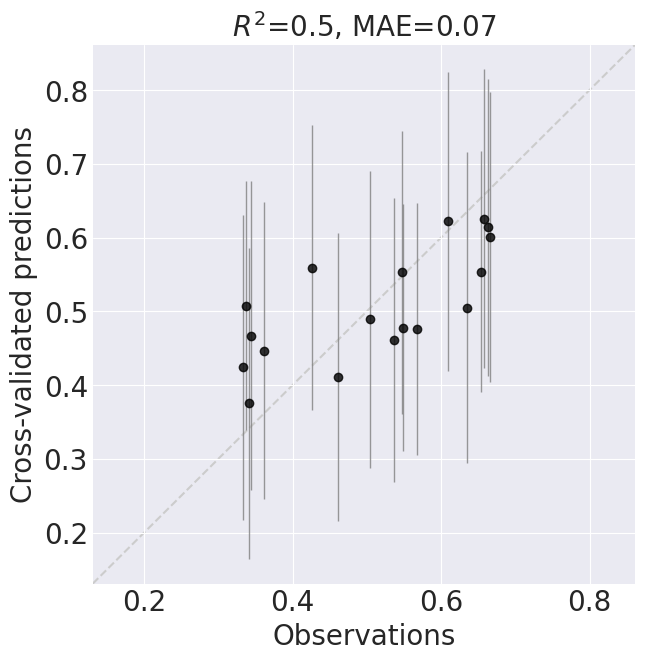

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(Normalizer(input_matrix, norm=max))
Done fitting L0 models in 32.79 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 21.15 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.084060,17.780560,0.058334,1.046887e-02,0.304286
Random Forest Regressor,0.023893,5.723855,0.021683,1.041014e-03,0.930819
Support Vector Regressor,0.079052,16.841553,0.028729,7.074586e-03,0.529855
Kernel Ridge Regressor,0.070296,13.766332,0.037393,6.339837e-03,0.578683
K-NN Regressor,0.057725,13.701250,0.045624,5.413692e-03,0.640230
Gaussian Process Regressor,0.000002,0.000362,0.000001,4.433805e-12,1.000000
Gradient Boosting Regressor,0.000326,0.059859,0.000398,2.647675e-07,0.999982
TPOT Regressor,0.041091,9.069495,0.022150,2.179084e-03,0.855188
Ensemble Model,0.032421,6.954530,0.017367,1.352748e-03,0.910102


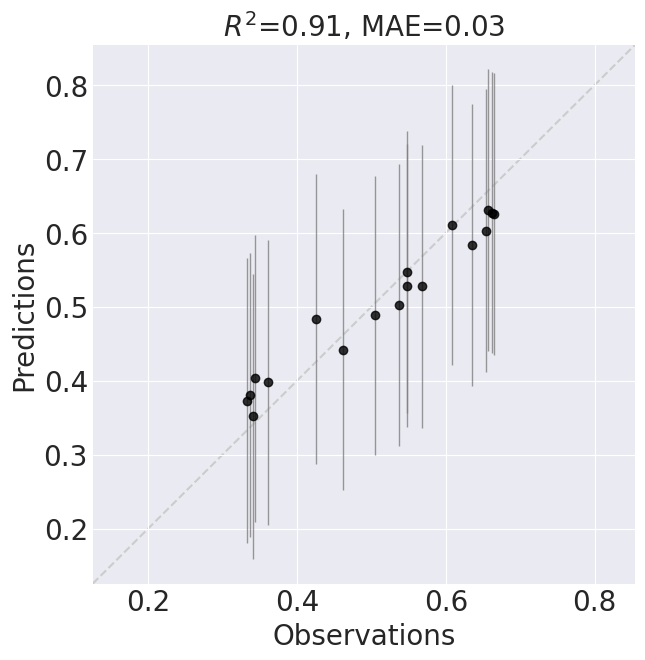

Done building models in 55.18 s
Finding all possible categorical designs…
Done finding categorical designs in 89.51 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.02 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,0.631515
1,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,0.626830
2,2.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.625690
3,2.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.625419
4,2.0,2.0,0.0,2.0,1.0,0.0,1.0,2.0,2.0,0.625407
5,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,0.624510


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.84 s


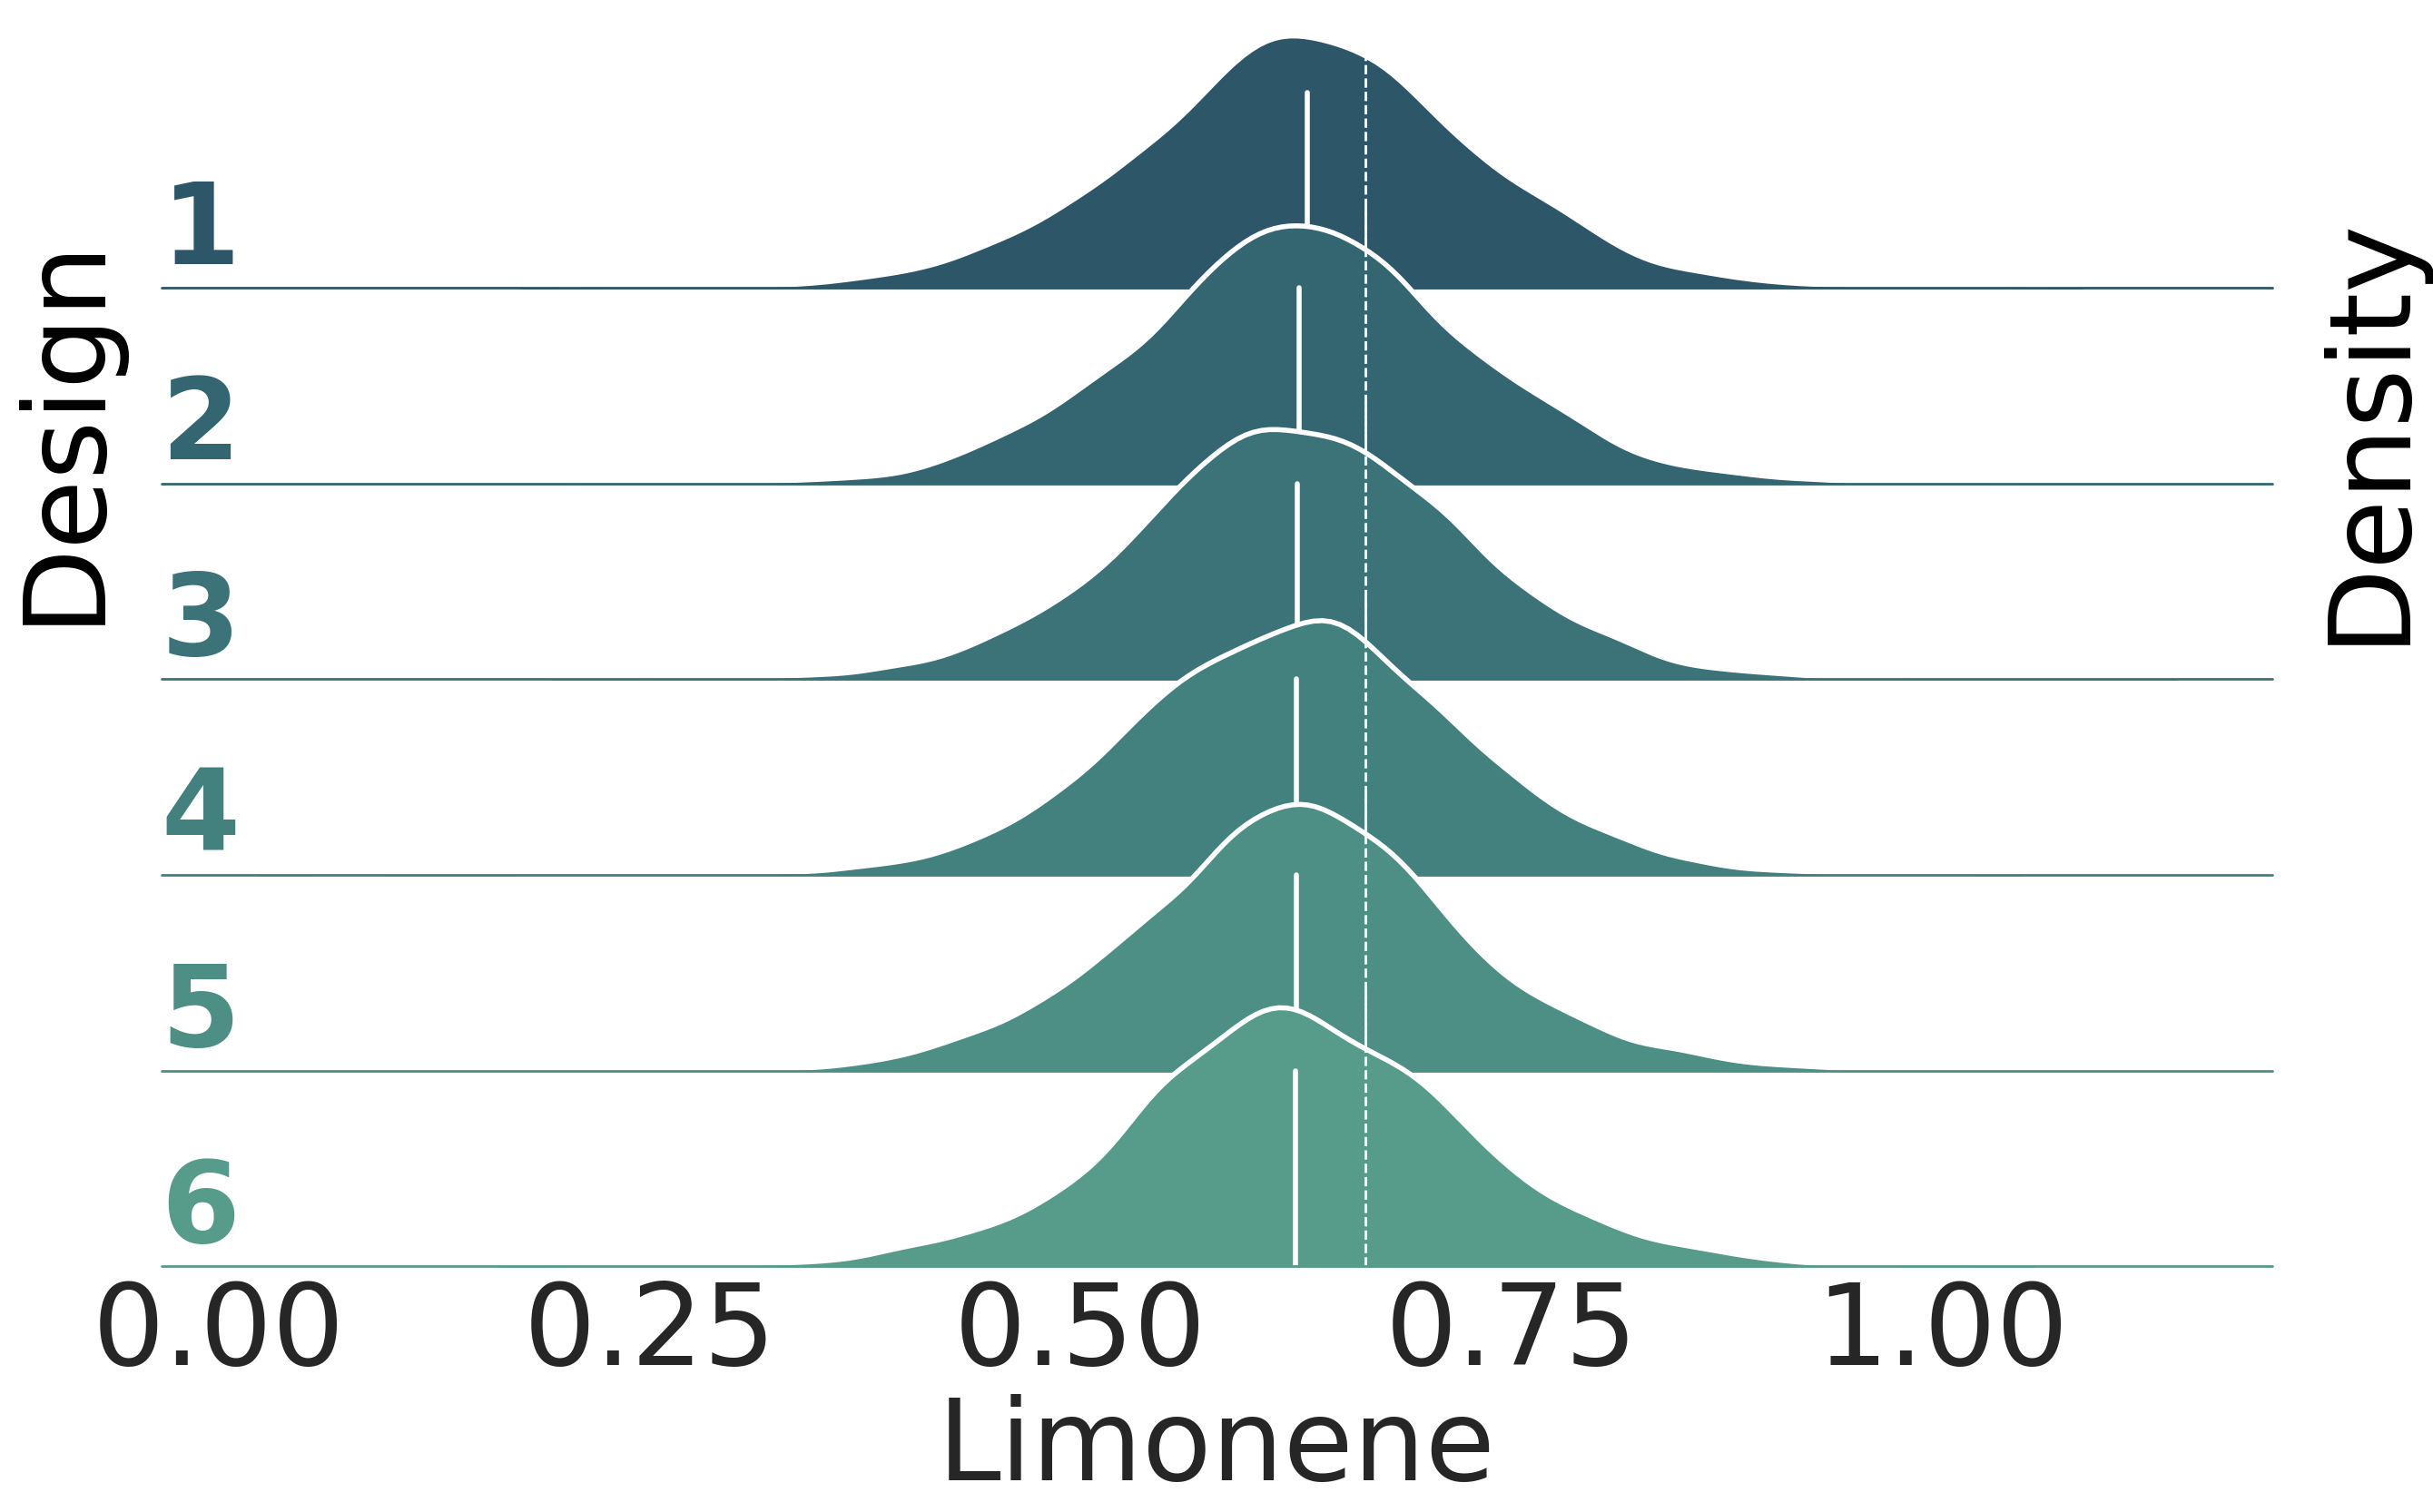

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.82 s
Done computing success probabilities in 0.82 s


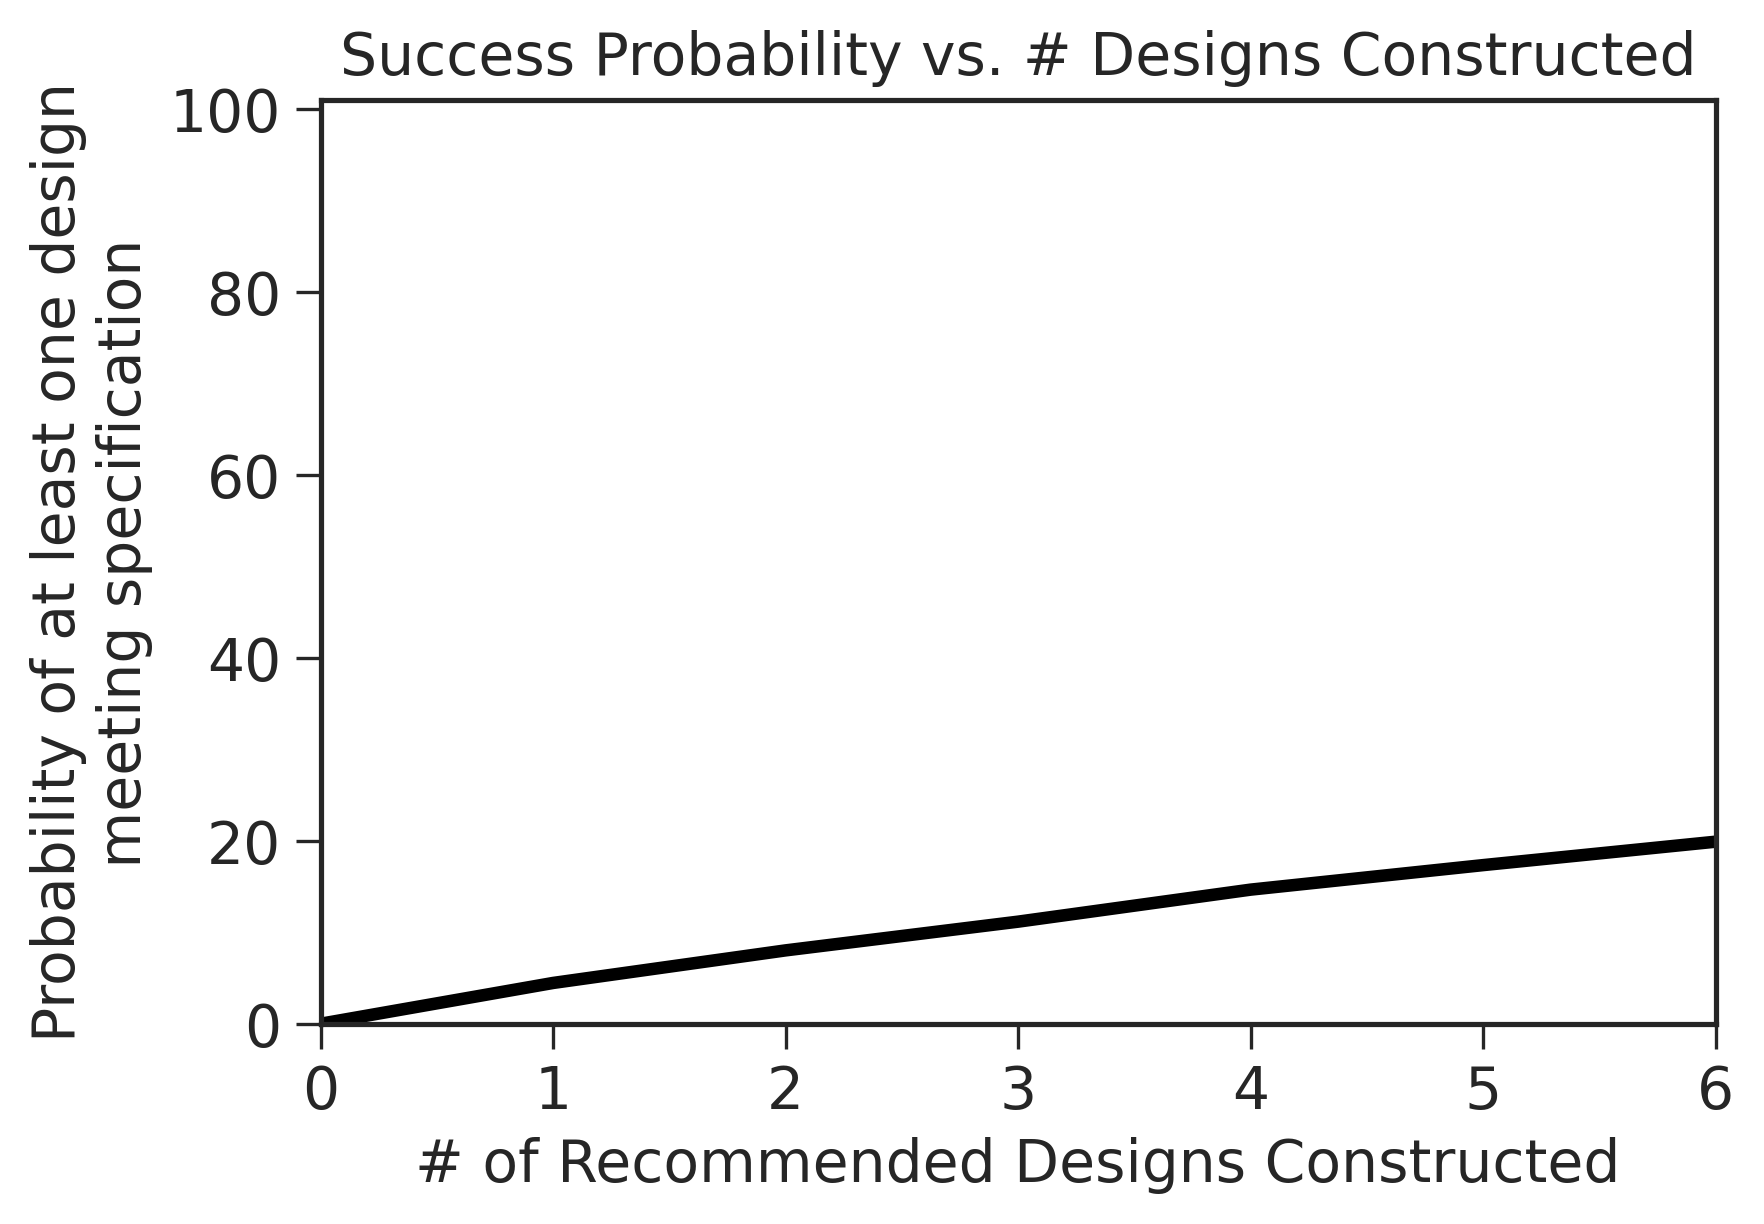

CPU times: user 7min 57s, sys: 6.68 s, total: 8min 4s
Wall time: 11min 9s


In [76]:
%%time
art = RecommendationEngine(df=df, alpha = 0, **art_params)

### alpha = 1.0

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 18 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(PCA(RobustScaler(input_matrix), iterated_power=10, svd_solver=randomized), l1_ratio=0.05, tol=1e-05)
Done fitting L0 models in 33.65 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 17.14 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(RidgeCV(PolynomialFeatures(RobustScaler(input_matrix), degree=2, include_bias=False, interaction_only=False)), l1_ratio=0.05, tol=0.1)
Done fitting L0 models in 35.79 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 27.98 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(SelectPercentile(input_matrix, percentile=46), l1_ratio=1.0, tol=0.0001)
Done fitting L0 models in 38.71 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.29 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(DecisionTreeRegressor(Normalizer(input_matrix, norm=max), max_depth=1, min_samples_leaf=20, min_samples_split=6), normalize=False)
Done fitting L0 models in 36.37 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.79 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(Normalizer(MinMaxScaler(Normalizer(input_matrix, norm=l2)), norm=max), normalize=True)
Done fitting L0 models in 34.98 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.73 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(ZeroCount(Normalizer(input_matrix, norm=l2)), normalize=False)
Done fitting L0 models in 32.43 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.92 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(Normalizer(input_matrix, norm=max), C=20.0, dual=True, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.01)
Done fitting L0 models in 36.05 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.30 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(SelectFromModel(MinMaxScaler(input_matrix), max_features=0.7500000000000001, n_estimators=100, threshold=0.15000000000000002), l1_ratio=0.05, tol=0.001)
Done fitting L0 models in 34.43 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 26.06 s
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(SelectPercentile(input_matrix, percentile=28))
Done fitting L0 models in 33.81 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 25.35 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.215056,40.828378,0.208637,0.089778,-4.966262
Random Forest Regressor,0.072376,17.290856,0.059835,0.008819,0.413959
Support Vector Regressor,0.094059,20.397213,0.042217,0.010629,0.293616
Kernel Ridge Regressor,0.174776,35.118983,0.100840,0.040715,-1.705764
K-NN Regressor,0.072252,16.969728,0.051990,0.007923,0.473449
Gaussian Process Regressor,0.082084,19.720499,0.059111,0.010232,0.320037
Gradient Boosting Regressor,0.072659,18.210276,0.078116,0.011382,0.243632
TPOT Regressor,0.067126,15.402162,0.052614,0.007274,0.516590
Ensemble Model,0.074133,16.475661,0.045003,0.007521,0.500189


Done with 9-fold cross-validation in 534.40 s


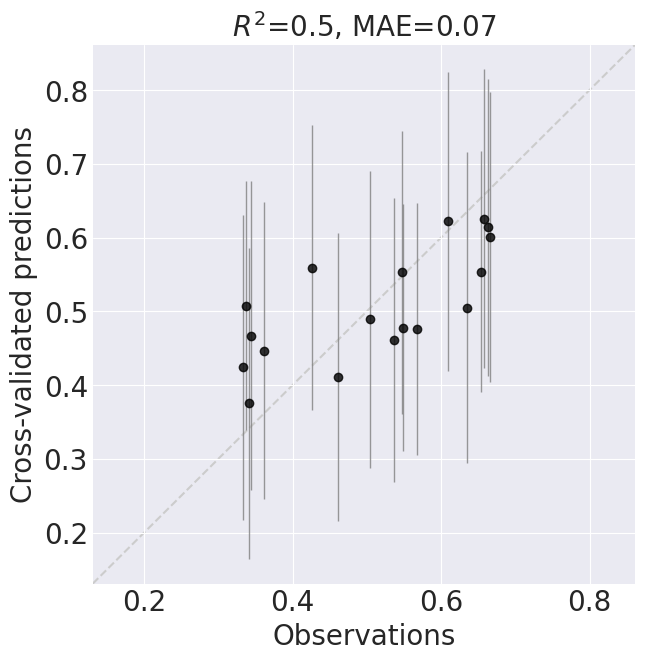

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(Normalizer(input_matrix, norm=max))
Done fitting L0 models in 32.78 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 21.49 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.084060,17.780560,0.058334,1.046887e-02,0.304286
Random Forest Regressor,0.023893,5.723855,0.021683,1.041014e-03,0.930819
Support Vector Regressor,0.079052,16.841553,0.028729,7.074586e-03,0.529855
Kernel Ridge Regressor,0.070296,13.766332,0.037393,6.339837e-03,0.578683
K-NN Regressor,0.057725,13.701250,0.045624,5.413692e-03,0.640230
Gaussian Process Regressor,0.000002,0.000362,0.000001,4.433805e-12,1.000000
Gradient Boosting Regressor,0.000326,0.059859,0.000398,2.647675e-07,0.999982
TPOT Regressor,0.041091,9.069495,0.022150,2.179084e-03,0.855188
Ensemble Model,0.032421,6.954530,0.017367,1.352748e-03,0.910102


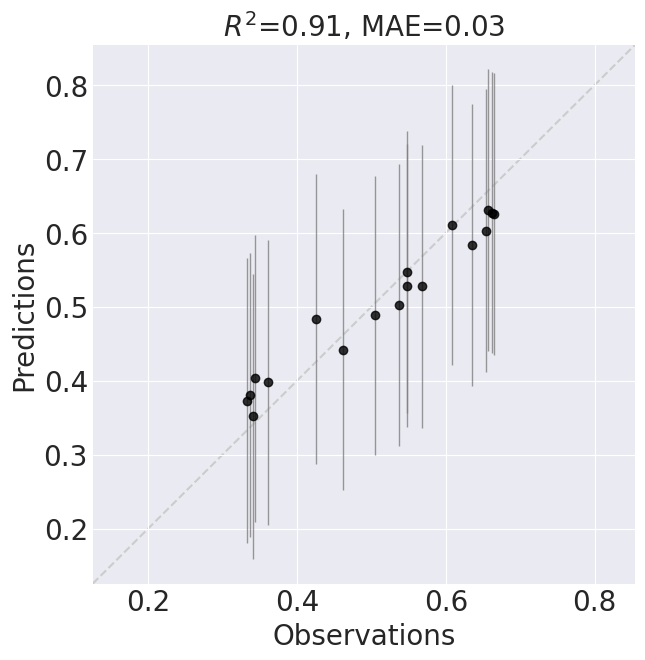

Done building models in 55.49 s
Finding all possible categorical designs…
Done finding categorical designs in 90.13 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.01 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.451594
1,2.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.457713
2,2.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.473731
3,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.459490
4,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,0.484496
5,1.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.463129


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.85 s


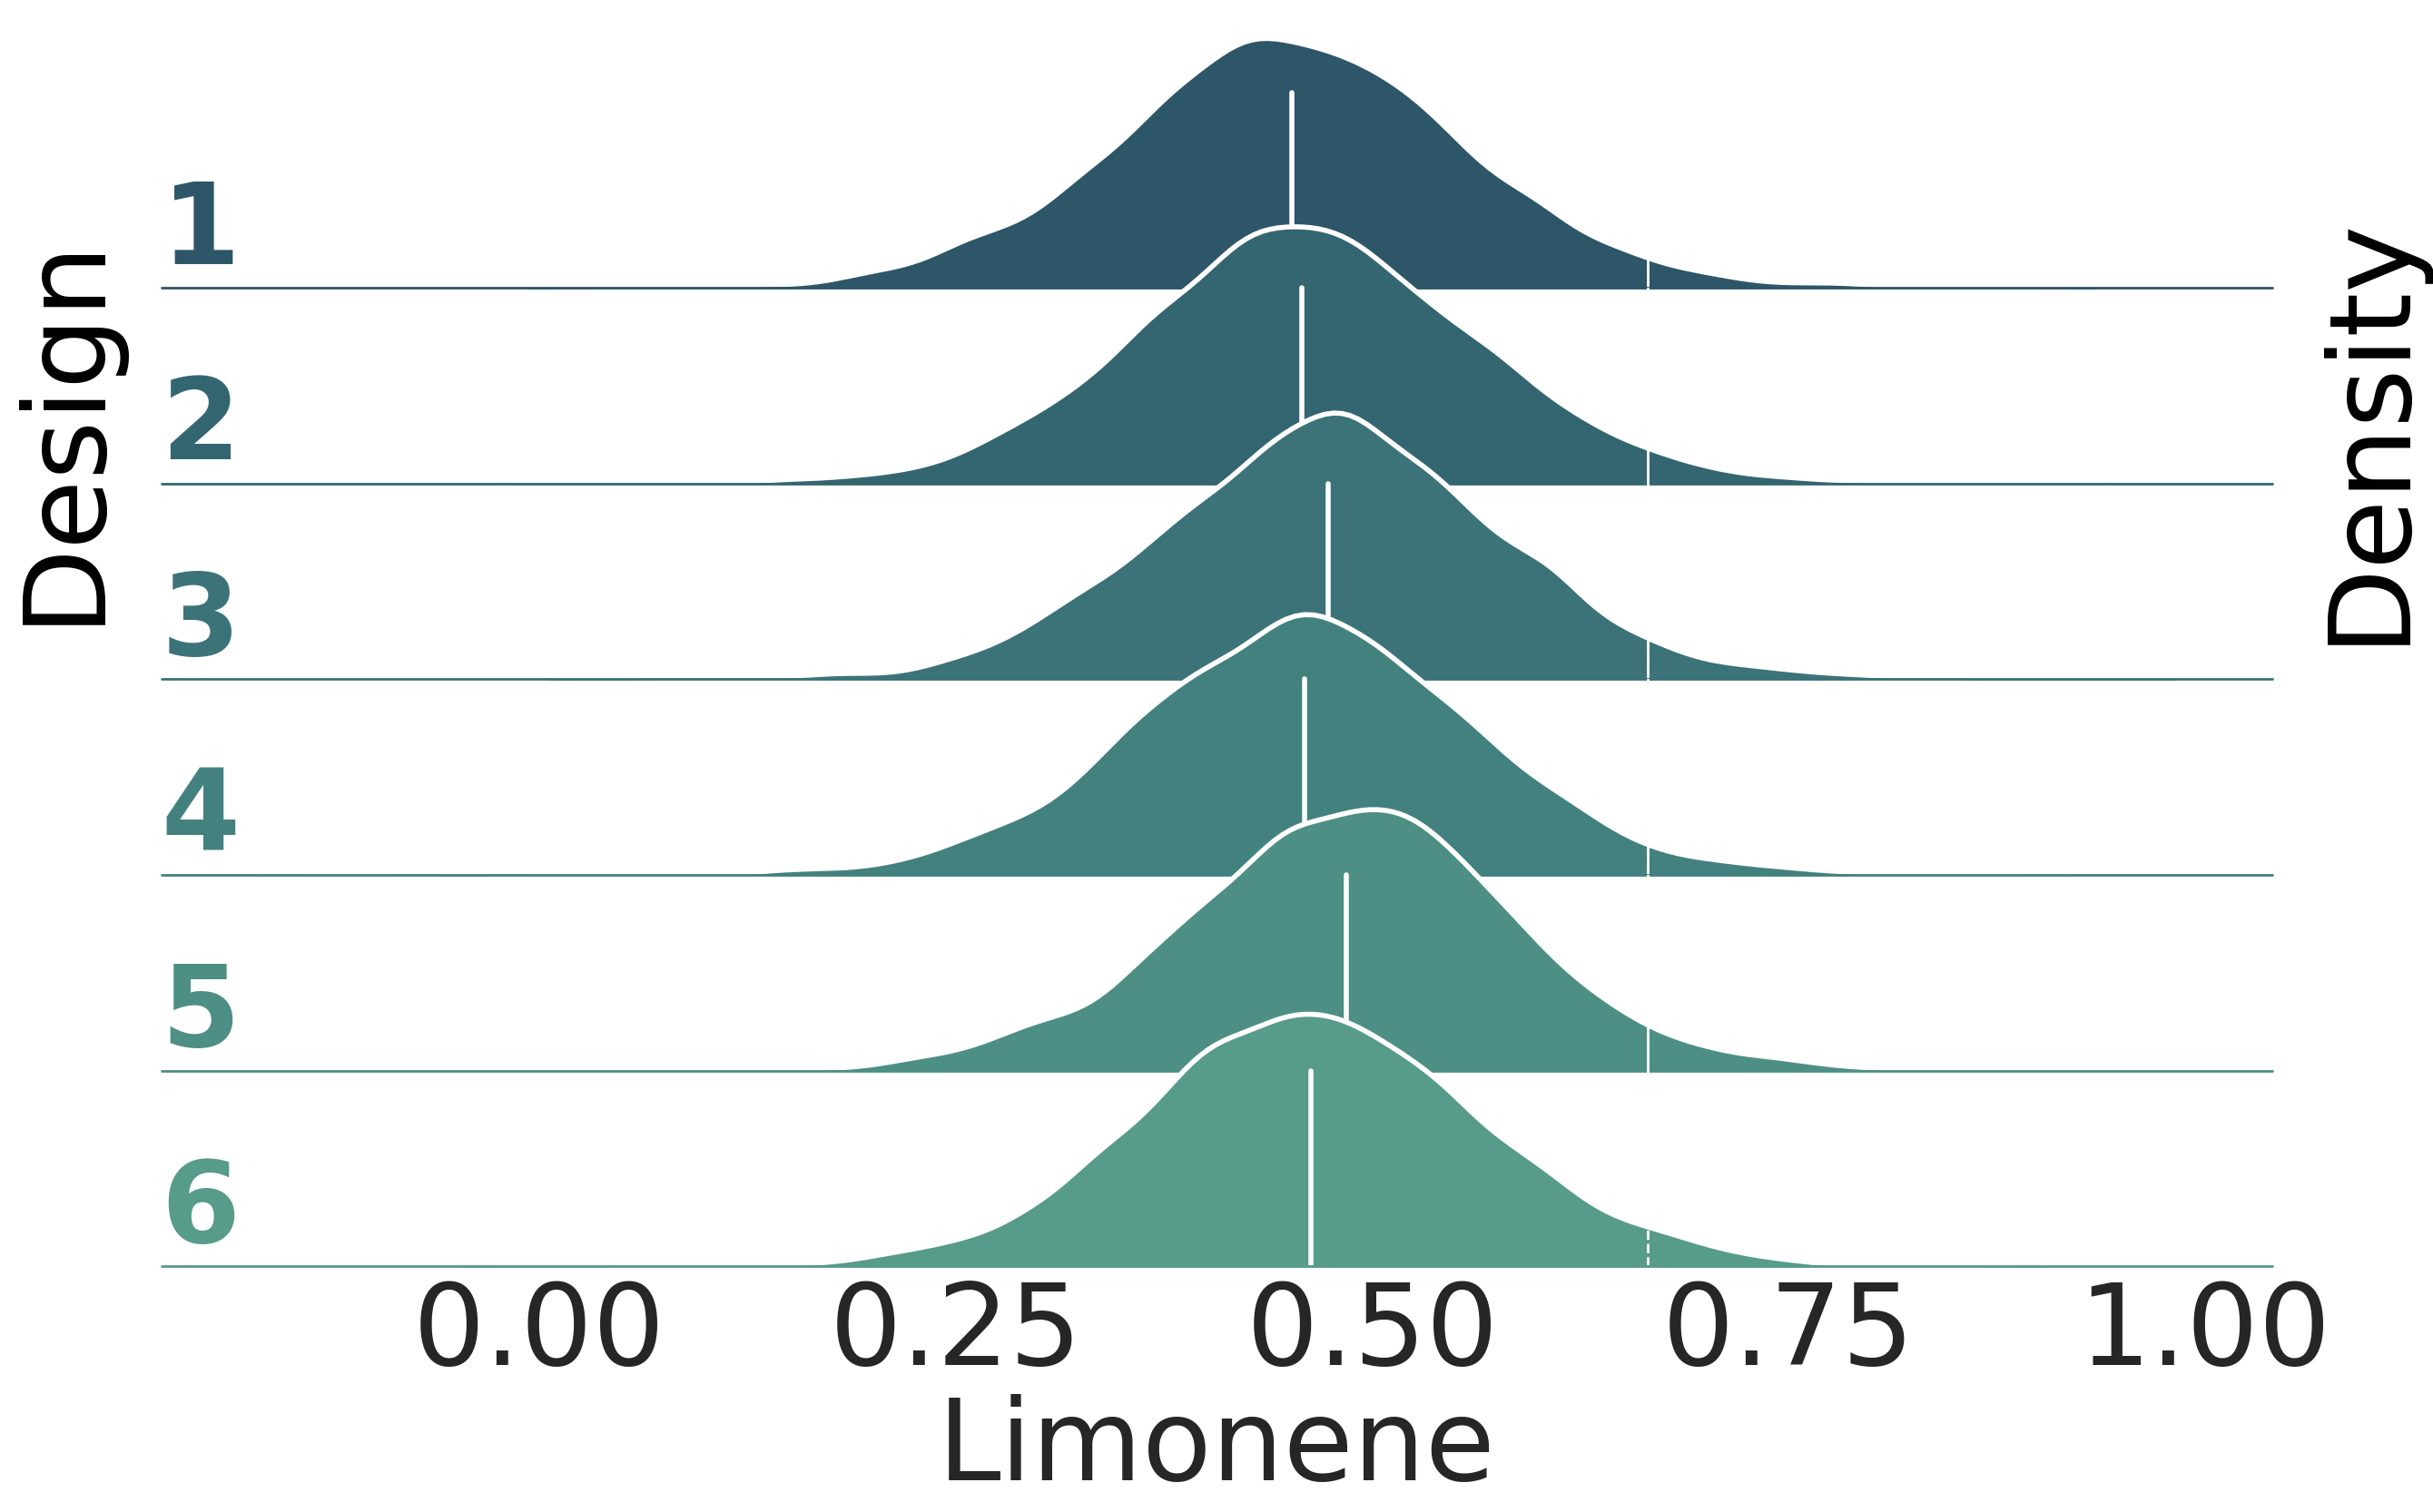

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.85 s
Done computing success probabilities in 0.85 s


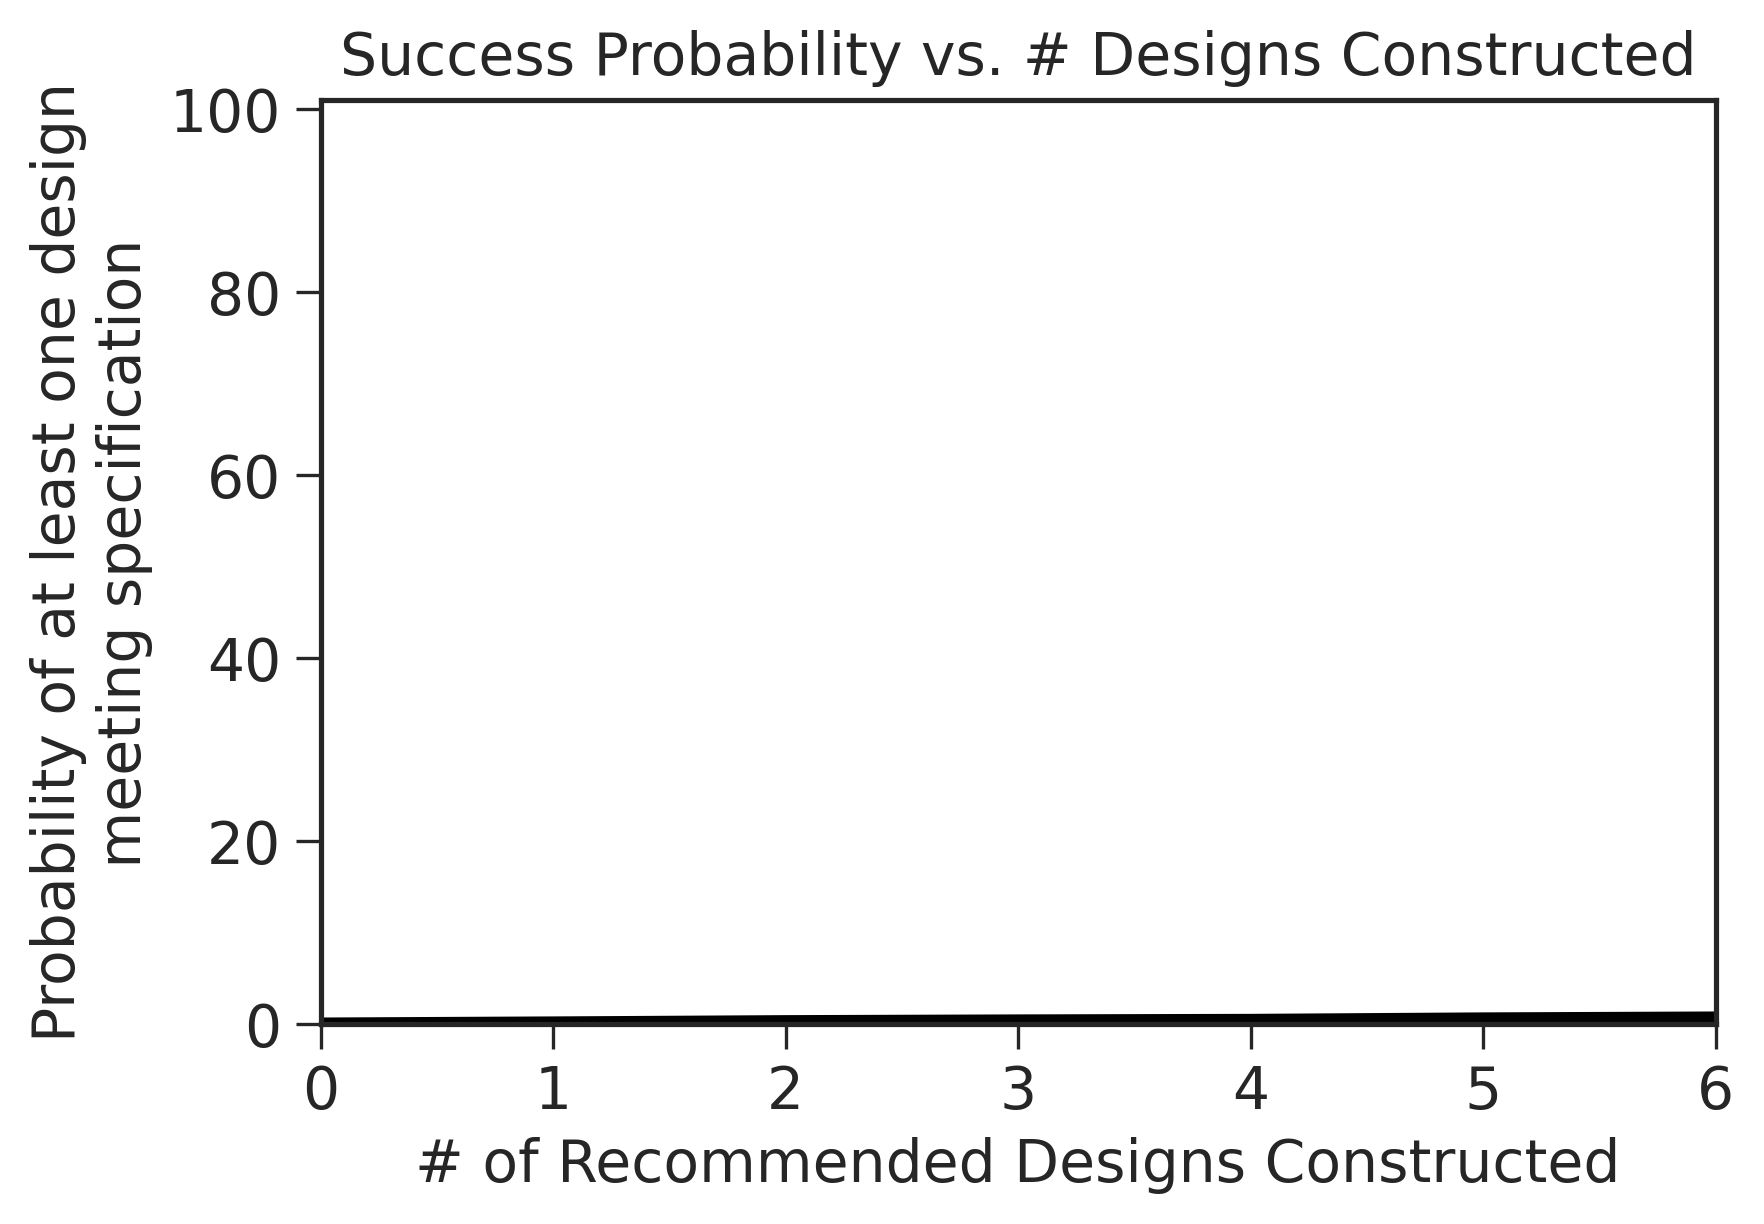

CPU times: user 8min 6s, sys: 6.95 s, total: 8min 13s
Wall time: 11min 24s


In [77]:
%%time
art = RecommendationEngine(df=df, alpha = 1, **art_params)

## Cycle 3

### Importing new 'experiment' data

In [78]:
"""

After Cycle 2, we got another 3 recommendations enzynmes' combinations when alpha = 0 and 3 when alpha = 1. 
Using these recommendations enzynmes' combinations to do silicon 'experiment' to get new sythetic data, 
which is the newly importing data. Using these 6 newly generated data to train the model again, which we 
called 'Cycle 3'. Similar as 'Cycle 2'.

"""
df1 = pd.read_csv("../data/Cycle 2/17rep_75noiseLevel_6recommend_cycle_2_weiyu_7strains_METABOLITE.csv.csv")
df2 = pd.read_csv("../data/Cycle 2/18rep_75noiseLevel_6recommend_cycle_2_weiyu_7strains_METABOLITE.csv.csv")
df3 = pd.read_csv("../data/Cycle 2/19rep_75noiseLevel_6recommend_cycle_2_weiyu_7strains_METABOLITE.csv.csv")

In [79]:
df1 = df1[df1['Time/hours'] == 24.0]
df2 = df2[df2['Time/hours'] == 24.0]
df3 = df3[df3['Time/hours'] == 24.0]

In [80]:
df = df1 + df2 + df3

In [81]:
df = df.iloc[1:,:]

In [82]:
df

,Strain,Time/hours,Acetyl-CoA,Acetoacetyl-CoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
193,Recommendation Strain 1Recommendation Strain 1...,72.0,0.391459,0.118678,0.108838,0.040482,0.108779,0.026815,0.009204,0.020252,0.111512,2.001600
290,Recommendation Strain 2Recommendation Strain 2...,72.0,0.391459,0.118678,0.108838,0.016129,0.047109,0.021639,0.009231,0.006150,0.109654,2.059277
387,Recommendation Strain 3Recommendation Strain 3...,72.0,0.391459,0.118678,0.108838,0.016158,0.108817,0.025431,0.009207,0.020252,0.110836,2.015129
484,Recommendation Strain 4Recommendation Strain 4...,72.0,0.377009,0.705074,0.132694,0.020728,0.049559,0.059883,0.003919,0.246673,0.814962,1.067124
581,Recommendation Strain 5Recommendation Strain 5...,72.0,0.377009,0.705074,0.132694,0.020814,0.115292,0.071811,0.003963,0.239006,0.817622,1.026182
678,Recommendation Strain 6Recommendation Strain 6...,72.0,0.532562,2.048706,0.021314,0.011709,0.079514,0.041498,0.015617,0.002803,0.081663,1.572413


In [83]:
df.index = np.linspace(0,5,6)

In [84]:
df = df.iloc[:,-1] / 3

In [85]:
df

0.0    0.667200
1.0    0.686426
2.0    0.671710
3.0    0.355708
4.0    0.342061
5.0    0.524138
Name: Limonene, dtype: float64

In [86]:
dfl = pd.read_csv("../data/Cycle 2/6RecommendationsgivenbyCycle2.csv")

In [87]:
dfl = dfl.iloc[:,[5,8]]

In [88]:
dfl

,Name*,Summary*
0,Recommendation Strain 1,AtoB_2_HMGS_2_HMGR_0_MK_1_PMK_0_PMD_1_GPPS_1_I...
1,Recommendation Strain 2,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_1_PMD_1_GPPS_1_I...
2,Recommendation Strain 3,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_1_GPPS_1_I...
3,Recommendation Strain 4,AtoB_2_HMGS_1_HMGR_0_MK_2_PMK_1_PMD_0_GPPS_2_I...
4,Recommendation Strain 5,AtoB_2_HMGS_1_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_2_I...
5,Recommendation Strain 6,AtoB_2_HMGS_0_HMGR_2_MK_2_PMK_0_PMD_0_GPPS_0_I...


In [89]:
long_strings = dfl.iloc[:,-1].values.tolist()

In [90]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [91]:
df_t = pd.DataFrame(dict_list)

In [92]:
dft = pd.concat([dfl.iloc[:,0],df_t], axis = 1)

In [93]:
dft

,Name*,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase
0,Recommendation Strain 1,2,2,0,1,0,1,1,1,2
1,Recommendation Strain 2,2,2,0,2,1,1,1,2,2
2,Recommendation Strain 3,2,2,0,2,0,1,1,1,2
3,Recommendation Strain 4,2,1,0,2,1,0,2,1,0
4,Recommendation Strain 5,2,1,0,2,0,0,2,1,0
5,Recommendation Strain 6,2,0,2,2,0,0,0,2,2


In [94]:
df.columns = ['Limonene']

In [95]:
df_c2 = pd.concat([dft, df], axis = 1)

In [96]:
df_c2

,Name*,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,Recommendation Strain 1,2,2,0,1,0,1,1,1,2,0.667200
1.0,Recommendation Strain 2,2,2,0,2,1,1,1,2,2,0.686426
2.0,Recommendation Strain 3,2,2,0,2,0,1,1,1,2,0.671710
3.0,Recommendation Strain 4,2,1,0,2,1,0,2,1,0,0.355708
4.0,Recommendation Strain 5,2,1,0,2,0,0,2,1,0,0.342061
5.0,Recommendation Strain 6,2,0,2,2,0,0,0,2,2,0.524138


In [97]:
df_c2.columns = ["Strain", "AtoB", "HMGS", "HMGR", "MK", "PMK", "PMD", "GPPS", "Idi", "Limonene Synthase", "Limonene"]

### Importing last cycle's new 'experiment' data

In [98]:
"""
Running the procedure in Cycle 2 again to get new dataframe

"""
df1 = pd.read_csv("../data/Cycle 1/17rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")
df2 = pd.read_csv("../data/Cycle 1/18rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")
df3 = pd.read_csv("../data/Cycle 1/19rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")

In [99]:
df1 = df1[df1['Time/hours'] == 24.0]
df2 = df2[df2['Time/hours'] == 24.0]
df3 = df3[df3['Time/hours'] == 24.0]

In [100]:
df = df1 + df2 + df3

In [101]:
df = df.iloc[1:,:]

In [102]:
df

,Strain,Time/hours,Acetyl-CoA,Acetoacetyl-CoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
193,Recommendation Strain 1Recommendation Strain 1...,72.0,0.391459,0.118678,0.108838,0.016406,0.108842,0.064453,0.009199,0.006146,0.115114,1.995933
290,Recommendation Strain 2Recommendation Strain 2...,72.0,0.391459,0.118678,0.108838,0.041175,0.108878,0.068192,0.009213,0.020270,0.117717,1.971433
387,Recommendation Strain 3Recommendation Strain 3...,72.0,1.119918,0.092411,0.120422,0.014996,0.099224,0.055696,0.008297,0.019781,0.099510,1.826951
484,Recommendation Strain 4Recommendation Strain 4...,72.0,1.119918,0.092411,0.120422,0.014729,0.017449,0.007003,0.003418,0.017424,0.098067,1.904209
581,Recommendation Strain 5Recommendation Strain 5...,72.0,2.232697,0.058167,0.096135,0.053846,0.010953,0.028975,0.005243,0.018276,0.063023,1.642588
678,Recommendation Strain 6Recommendation Strain 6...,72.0,0.391459,0.118678,0.108838,0.095449,0.108910,0.030039,0.021335,0.026203,0.114948,1.960085


In [103]:
df.index = np.linspace(0,5,6)

In [104]:
df = df.iloc[:,-1] / 3

In [105]:
df

0.0    0.665311
1.0    0.657144
2.0    0.608984
3.0    0.634736
4.0    0.547529
5.0    0.653362
Name: Limonene, dtype: float64

In [106]:
dfl = pd.read_csv("../data/Cycle 1/6RecommendationsgivenbyCycle1.csv")

In [107]:
dfl = dfl.iloc[:,[5,8]]

In [108]:
dfl

,Name*,Summary*
0,Recommendation Strain 1,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
1,Recommendation Strain 2,AtoB_2_HMGS_2_HMGR_0_MK_1_PMK_0_PMD_0_GPPS_1_I...
2,Recommendation Strain 3,AtoB_1_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
3,Recommendation Strain 4,AtoB_1_HMGS_2_HMGR_0_MK_2_PMK_2_PMD_2_GPPS_2_I...
4,Recommendation Strain 5,AtoB_0_HMGS_2_HMGR_0_MK_0_PMK_2_PMD_0_GPPS_1_I...
5,Recommendation Strain 6,AtoB_2_HMGS_2_HMGR_0_MK_0_PMK_0_PMD_1_GPPS_0_I...


In [109]:
long_strings = dfl.iloc[:,-1].values.tolist()

In [110]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [111]:
df_t = pd.DataFrame(dict_list)

In [112]:
dft = pd.concat([dfl.iloc[:,0],df_t], axis = 1)

In [113]:
dft

,Name*,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase
0,Recommendation Strain 1,2,2,0,2,0,0,1,2,2
1,Recommendation Strain 2,2,2,0,1,0,0,1,1,2
2,Recommendation Strain 3,1,2,0,2,0,0,1,1,2
3,Recommendation Strain 4,1,2,0,2,2,2,2,2,2
4,Recommendation Strain 5,0,2,0,0,2,0,1,1,2
5,Recommendation Strain 6,2,2,0,0,0,1,0,0,2


In [114]:
df.columns = ['Limonene']

In [115]:
df_c1 = pd.concat([dft, df], axis = 1)

In [116]:
df_c1

,Name*,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,Recommendation Strain 1,2,2,0,2,0,0,1,2,2,0.665311
1.0,Recommendation Strain 2,2,2,0,1,0,0,1,1,2,0.657144
2.0,Recommendation Strain 3,1,2,0,2,0,0,1,1,2,0.608984
3.0,Recommendation Strain 4,1,2,0,2,2,2,2,2,2,0.634736
4.0,Recommendation Strain 5,0,2,0,0,2,0,1,1,2,0.547529
5.0,Recommendation Strain 6,2,2,0,0,0,1,0,0,2,0.653362


In [117]:
df_c1.columns = ["Strain", "AtoB", "HMGS", "HMGR", "MK", "PMK", "PMD", "GPPS", "Idi", "Limonene Synthase", "Limonene"]

### Importing original data

In [118]:
"""
Also importing the original data to concat them together.
"""
df4 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/17rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")
df5 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/18rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")
df6 = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/19rep_75noiseLevel_12strains_initial_design_seed1_7.5%NOISE12strains_METABOLITE.csv.csv")

In [119]:
df_l = pd.read_csv("../data/75noiseLevel_12strains_initial_design_seed1/12strains_initial_design_seed1.csv")

In [120]:
df_l = df_l.iloc[:,[5,8]]

In [121]:
df_l

,Name*,Summary*
0,Strain 1,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_1_GPPS_0_I...
1,Strain 2,AtoB_0_HMGS_0_HMGR_2_MK_0_PMK_2_PMD_2_GPPS_1_I...
2,Strain 3,AtoB_2_HMGS_0_HMGR_0_MK_0_PMK_1_PMD_2_GPPS_1_I...
3,Strain 4,AtoB_0_HMGS_2_HMGR_2_MK_0_PMK_2_PMD_2_GPPS_0_I...
4,Strain 5,AtoB_2_HMGS_1_HMGR_2_MK_1_PMK_0_PMD_1_GPPS_2_I...
5,Strain 6,AtoB_1_HMGS_0_HMGR_1_MK_0_PMK_1_PMD_0_GPPS_2_I...
6,Strain 7,AtoB_2_HMGS_2_HMGR_0_MK_2_PMK_0_PMD_0_GPPS_1_I...
7,Strain 8,AtoB_0_HMGS_1_HMGR_1_MK_1_PMK_1_PMD_2_GPPS_2_I...
8,Strain 9,AtoB_1_HMGS_1_HMGR_1_MK_2_PMK_0_PMD_1_GPPS_0_I...
9,Strain 10,AtoB_1_HMGS_0_HMGR_2_MK_1_PMK_2_PMD_1_GPPS_2_I...


In [122]:
long_strings = df_l.iloc[:,-1].values.tolist()

In [123]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [124]:
df_t = pd.DataFrame(dict_list)

In [125]:
df = pd.concat([df_l.iloc[:,0],df_t], axis = 1)

In [126]:
# append the WT group to the dataframe
new_row = {' Name*': 'WT'}
for col in df.columns[1:]:
    new_row[col] = 1

In [127]:
df_wt = pd.DataFrame([new_row])

In [128]:
df = pd.concat([df_wt, df], ignore_index=True)

In [129]:
df4 = df4[df4['Time/hours'] == 24.0]
df5 = df5[df5['Time/hours'] == 24.0]
df6 = df6[df6['Time/hours'] == 24.0]

dfl = df4 + df5 + df6

dfl = dfl.iloc[:,-1]

dfl.index = np.linspace(0, 11, 12)

In [130]:
df = pd.concat([df, dfl / 3], axis = 1, ignore_index=True)

In [131]:
df.columns = ['Strain', 'AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi', 'Limonene Synthase', 'Limonene']

In [132]:
df

,Strain,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,WT,1,1,1,1,1,1,1,1,1,0.548045
1.0,Strain 1,2,2,0,2,0,1,0,2,0,0.425960
2.0,Strain 2,0,0,2,0,2,2,1,1,0,0.340830
3.0,Strain 3,2,0,0,0,1,2,1,1,0,0.333494
4.0,Strain 4,0,2,2,0,2,2,0,2,2,0.567516
5.0,Strain 5,2,1,2,1,0,1,2,0,1,0.343577
6.0,Strain 6,1,0,1,0,1,0,2,2,1,0.461772
7.0,Strain 7,2,2,0,2,0,0,1,1,2,0.662760
8.0,Strain 8,0,1,1,1,1,2,2,2,1,0.504226
9.0,Strain 9,1,1,1,2,0,1,0,0,1,0.536793


In [133]:
dfnew = pd.concat([df, df_c1, df_c2], axis = 0, ignore_index = True)

In [134]:
dfnew.loc[12:17, 'Strain'] = dfnew.loc[12:17, 'Strain'] + ' (Cycle 1)'
dfnew.loc[18:23, 'Strain'] = dfnew.loc[18:23, 'Strain'] + ' (Cycle 2)'

In [135]:
dfnew

,Strain,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,WT,1,1,1,1,1,1,1,1,1,0.548045
1,Strain 1,2,2,0,2,0,1,0,2,0,0.425960
2,Strain 2,0,0,2,0,2,2,1,1,0,0.340830
3,Strain 3,2,0,0,0,1,2,1,1,0,0.333494
4,Strain 4,0,2,2,0,2,2,0,2,2,0.567516
5,Strain 5,2,1,2,1,0,1,2,0,1,0.343577
6,Strain 6,1,0,1,0,1,0,2,2,1,0.461772
7,Strain 7,2,2,0,2,0,0,1,1,2,0.662760
8,Strain 8,0,1,1,1,1,2,2,2,1,0.504226
9,Strain 9,1,1,1,2,0,1,0,0,1,0.536793


### Transform the new data to align the ART's input format

In [136]:
dfnew = pd.melt(dfnew, id_vars=['Strain'], 
                    value_vars=['AtoB', 'HMGS', 'HMGR', 'MK','PMK','PMD','GPPS','Idi','Limonene Synthase','Limonene'],
                    var_name='Measurement Type', value_name='Value')

In [137]:
dfnew

,Strain,Measurement Type,Value
0,WT,AtoB,1
1,Strain 1,AtoB,2
2,Strain 2,AtoB,0
3,Strain 3,AtoB,2
4,Strain 4,AtoB,0
...,...,...,...
235,Recommendation Strain 2 (Cycle 2),Limonene,0.686426
236,Recommendation Strain 3 (Cycle 2),Limonene,0.67171
237,Recommendation Strain 4 (Cycle 2),Limonene,0.355708
238,Recommendation Strain 5 (Cycle 2),Limonene,0.342061


In [138]:
dfnew.to_csv("../data/Level_new_cycle3_data.csv", index = False)

### Defining parameters

In [155]:
user_params = {
    'data_file': '../data/Level_new_cycle3_data.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD',
                   'GPPS', 'Idi', 'Limonene Synthase'],  # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 6,  # Number of recommendations to be provided
    'max_mcmc_cores': 2,
    'cross_val': True,
    'output_dir': '../results/Level_result_Cycle3',                          # Directory to store output files
    'verbose': 1,                                                 # Amount of information to be displayed
}

In [156]:
cycle = 3

In [157]:
df = utils.load_study(data_file=user_params['data_file'])

In [158]:
df.columns = ['Line Name', 'Measurement Type', 'Value']

In [159]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    #'alpha': user_params['alpha'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'],
    'input_var_type': 'categorical',
    'cross_val_partitions': 12,                
    #'last_dashes_denote_replicates': False,
}

In [160]:
df

,Line Name,Measurement Type,Value
0,WT,AtoB,1.000000
1,Strain 1,AtoB,2.000000
2,Strain 2,AtoB,0.000000
3,Strain 3,AtoB,2.000000
4,Strain 4,AtoB,0.000000
...,...,...,...
235,Recommendation Strain 2 (Cycle 2),Limonene,0.686426
236,Recommendation Strain 3 (Cycle 2),Limonene,0.671710
237,Recommendation Strain 4 (Cycle 2),Limonene,0.355708
238,Recommendation Strain 5 (Cycle 2),Limonene,0.342061


### alpha = 0

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 24 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(ZeroCount(input_matrix), learning_rate=1.0, max_depth=3, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 43.93 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.33 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(CombineDFs(ZeroCount(ZeroCount(PolynomialFeatures(ZeroCount(input_matrix), degree=2, include_bias=False, interaction_only=False))), input_matrix))
Done fitting L0 models in 25.55 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.77 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(ZeroCount(MinMaxScaler(StandardScaler(input_matrix))), l1_ratio=0.05, tol=0.01)
Done fitting L0 models in 41.40 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.44 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(Normalizer(input_matrix, norm=l2))
Done fitting L0 models in 46.11 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.26 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(OneHotEncoder(RobustScaler(ZeroCount(input_matrix)), minimum_fraction=0.1, sparse=False, threshold=10), l1_ratio=0.1, tol=0.0001)
Done fitting L0 models in 36.06 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.59 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)
Done fitting L0 models in 46.61 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.65 s
Fitting L0 models…
Building TPOT models…
Best pipeline: GradientBoostingRegressor(Normalizer(input_matrix, norm=l2), alpha=0.75, learning_rate=0.1, loss=huber, max_depth=9, max_features=0.5, min_samples_leaf=2, min_samples_split=8, n_estimators=100, subsample=0.7000000000000001)
Done fitting L0 models in 60.99 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 21.53 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(ZeroCount(input_matrix)), learning_rate=0.5, loss=square, n_estimators=100)
Done fitting L0 models in 56.05 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 20.69 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(ZeroCount(Normalizer(input_matrix, norm=l2)), l1_ratio=0.30000000000000004, tol=1e-05)
Done fitting L0 models in 32.59 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.14 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(Normalizer(input_matrix, norm=max), normalize=True)
Done fitting L0 models in 28.57 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.34 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(ZeroCount(AdaBoostRegressor(RidgeCV(input_matrix), learning_rate=0.5, loss=linear, n_estimators=100)))
Done fitting L0 models in 42.11 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.96 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(PolynomialFeatures(RidgeCV(Normalizer(input_matrix, norm=l2)), degree=2, include_bias=False, interaction_only=False), normalize=False)
Done fitting L0 models in 49.74 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 26.30 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.143371,28.961285,0.114686,0.033708,-1.005274
Random Forest Regressor,0.054006,12.661817,0.053756,0.005806,0.654581
Support Vector Regressor,0.090804,19.395861,0.037419,0.009646,0.426192
Kernel Ridge Regressor,0.150670,30.276432,0.114023,0.035703,-1.123915
K-NN Regressor,0.072122,18.090565,0.067793,0.009797,0.417162
Gaussian Process Regressor,0.059127,14.451447,0.057884,0.006847,0.592704
Gradient Boosting Regressor,0.060490,13.964770,0.063744,0.007722,0.540601
TPOT Regressor,0.053385,11.813948,0.051391,0.005491,0.673345
Ensemble Model,0.056204,12.585034,0.037622,0.004574,0.727883


Done with 12-fold cross-validation in 812.76 s


<Figure size 600x600 with 0 Axes>

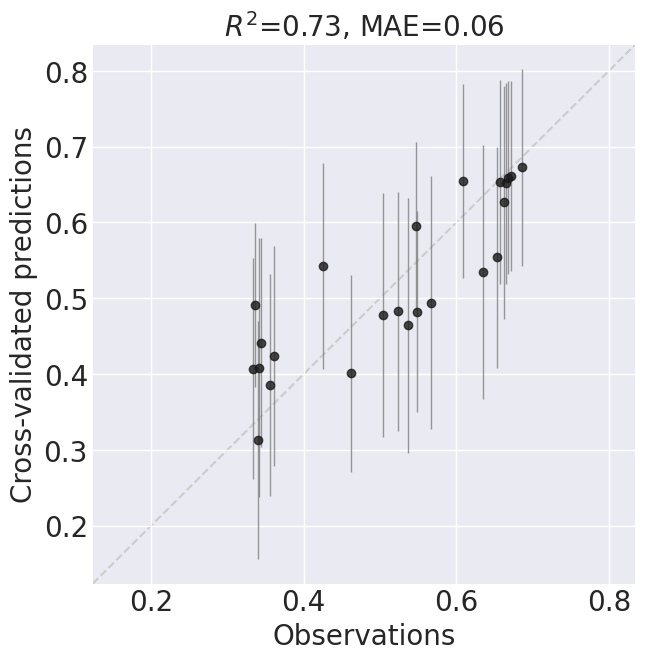

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(RobustScaler(StandardScaler(ZeroCount(input_matrix))))
Done fitting L0 models in 40.30 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 24.47 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.877133e-02,19.260228,6.179803e-02,1.169935e-02,0.304017
Random Forest Regressor,1.893241e-02,4.361924,1.950699e-02,7.389585e-04,0.956040
Support Vector Regressor,8.116291e-02,17.035157,2.832903e-02,7.389953e-03,0.560379
Kernel Ridge Regressor,5.967892e-02,11.658325,4.133604e-02,5.270242e-03,0.686478
K-NN Regressor,5.840030e-02,14.259077,5.413514e-02,6.341208e-03,0.622768
Gaussian Process Regressor,7.138594e-09,0.000001,7.997260e-09,1.149157e-16,1.000000
Gradient Boosting Regressor,3.735910e-04,0.065840,4.051146e-04,3.036880e-07,0.999982
TPOT Regressor,2.859726e-02,6.299410,1.950752e-02,1.198347e-03,0.928711
Ensemble Model,1.921158e-02,4.137260,1.006125e-02,4.703134e-04,0.972022


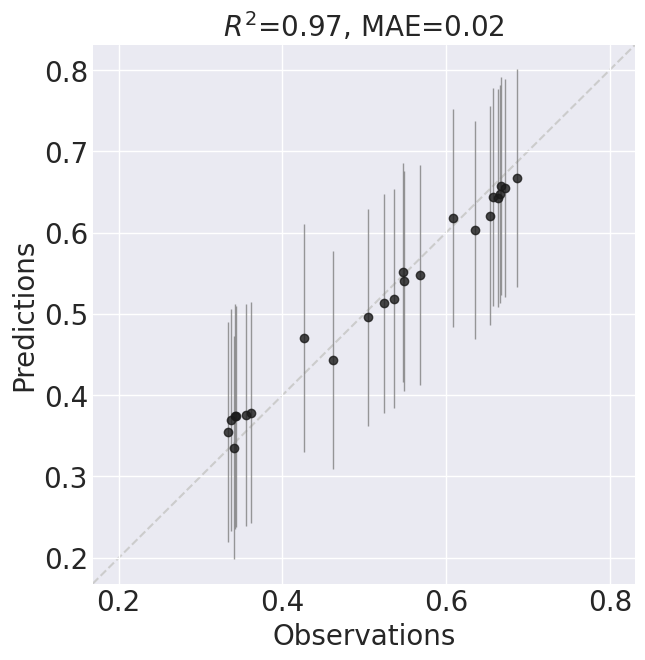

Done building models in 66.31 s
Finding all possible categorical designs…
Done finding categorical designs in 89.66 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.01 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,0.664459
1,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.663920
2,2.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.662276
3,2.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,0.660705
4,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.659729
5,2.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,2.0,0.658370


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.87 s


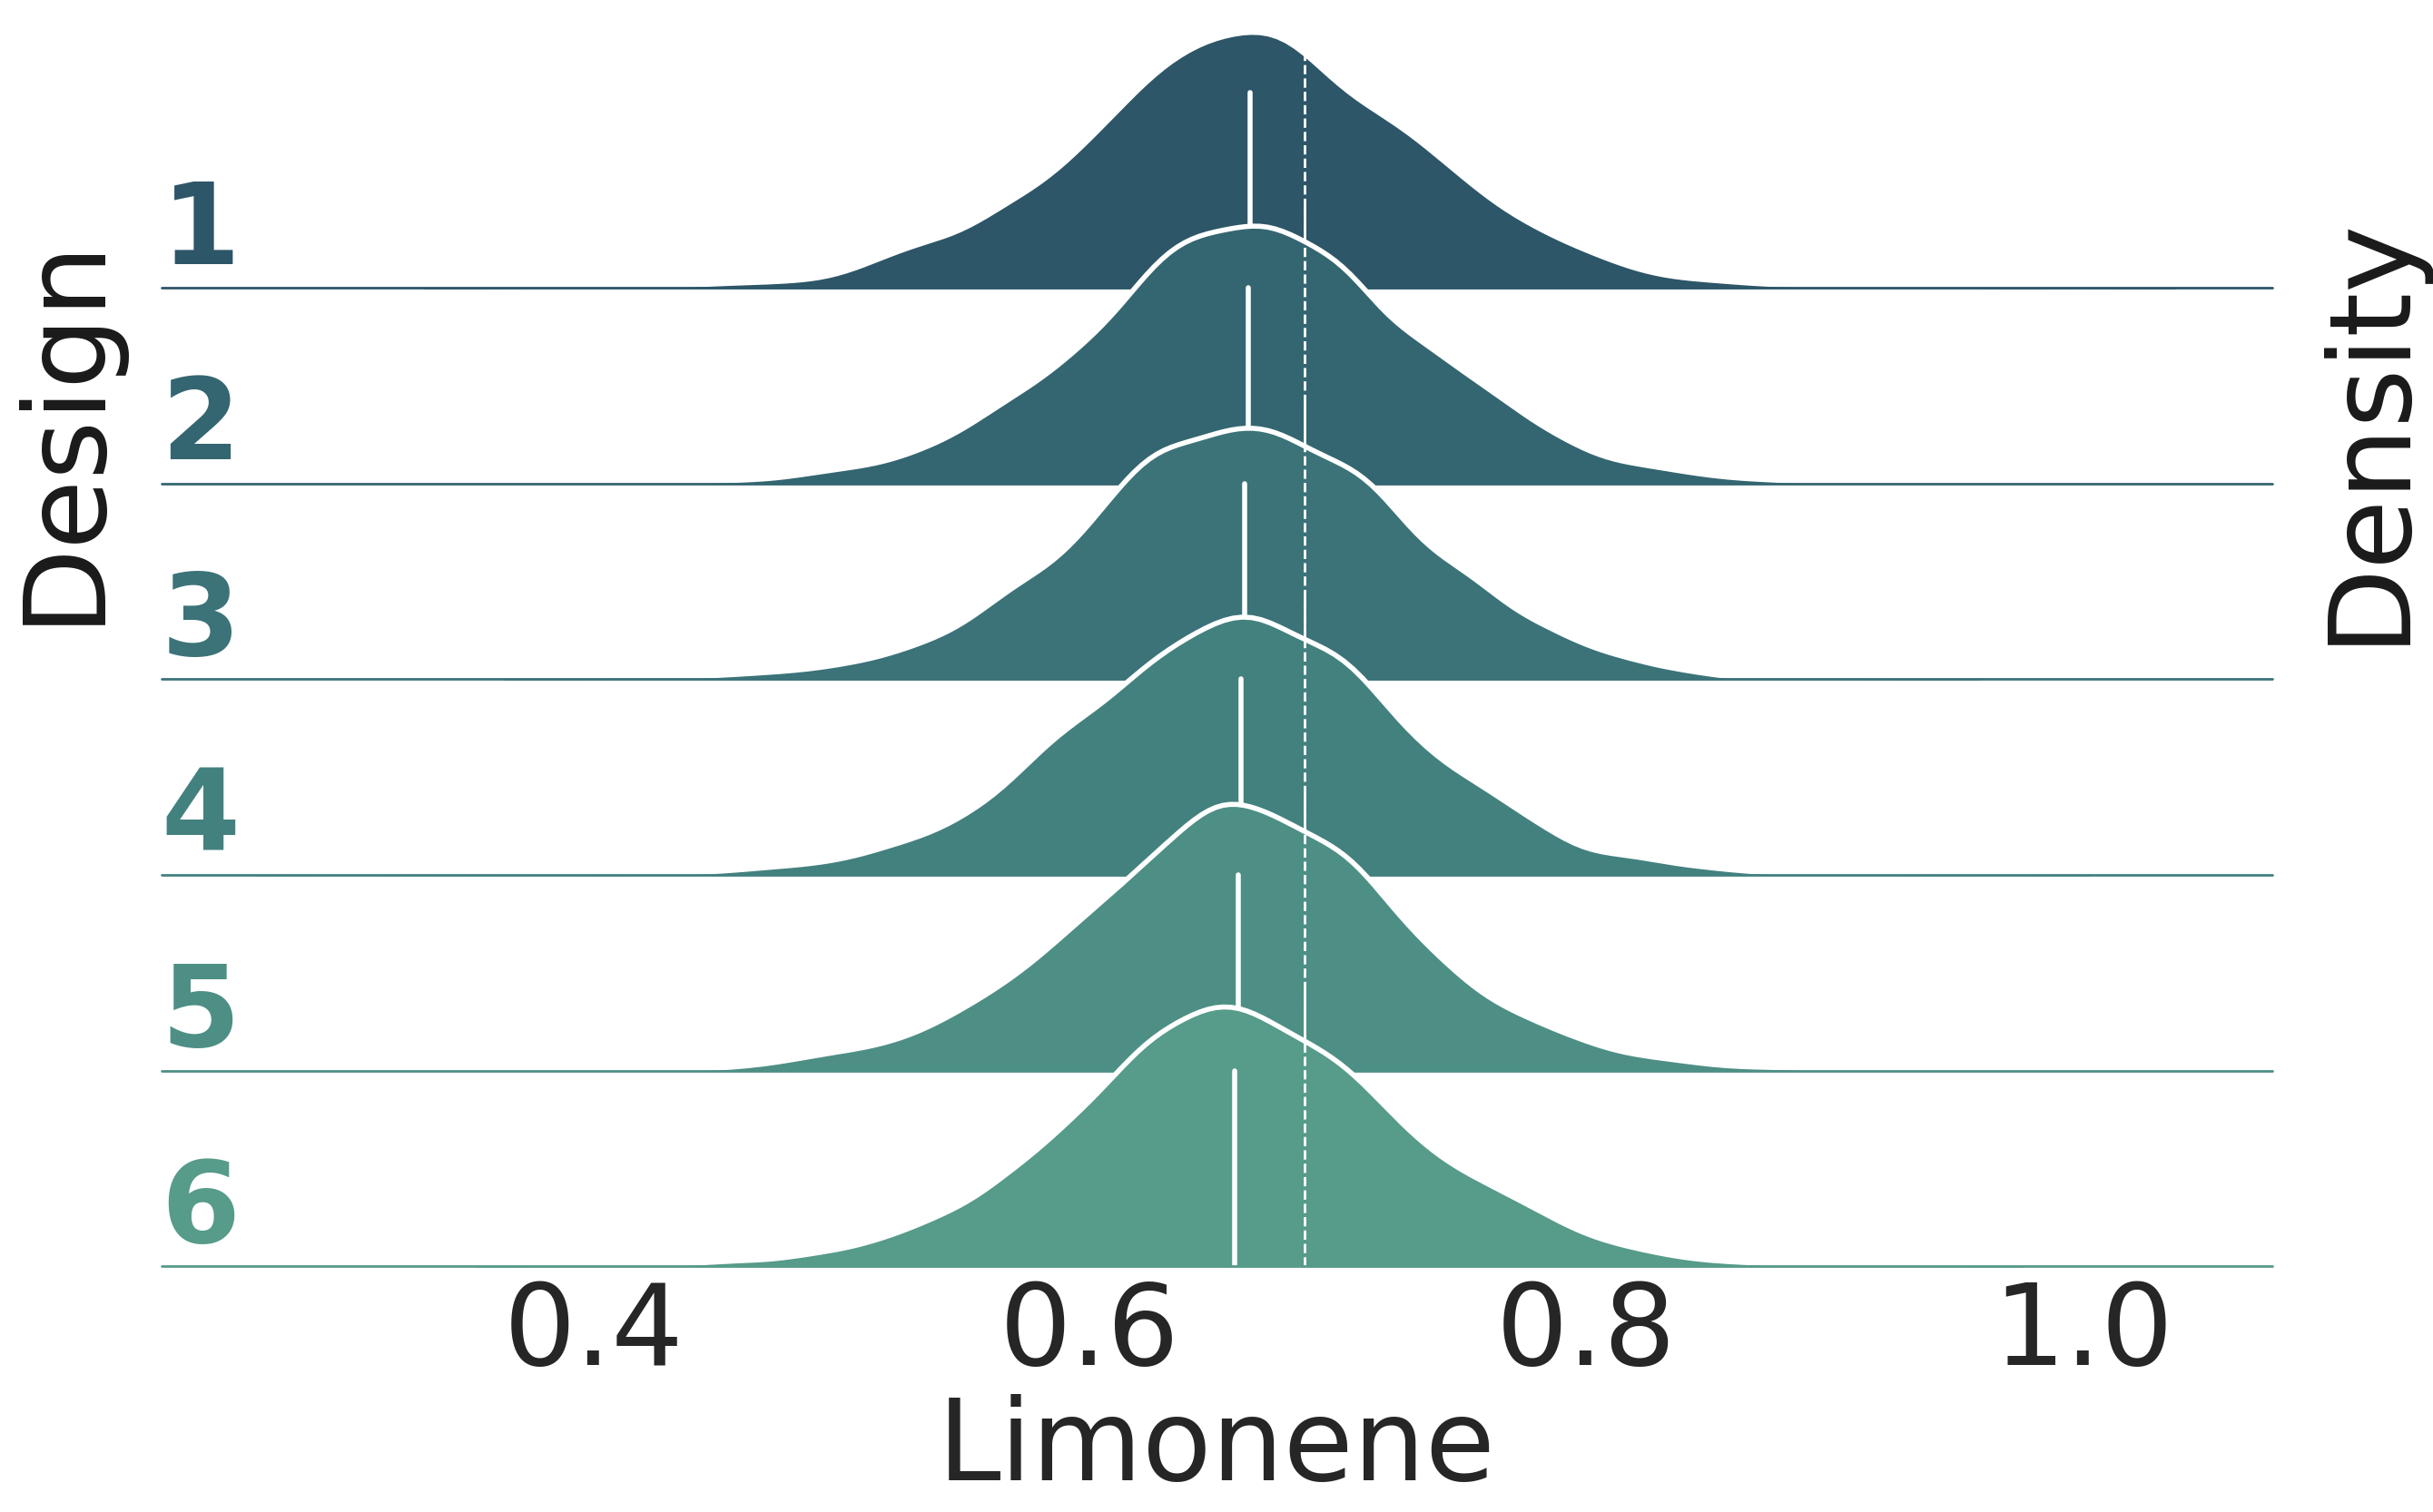

Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.23 s
Done computing success probabilities in 1.23 s


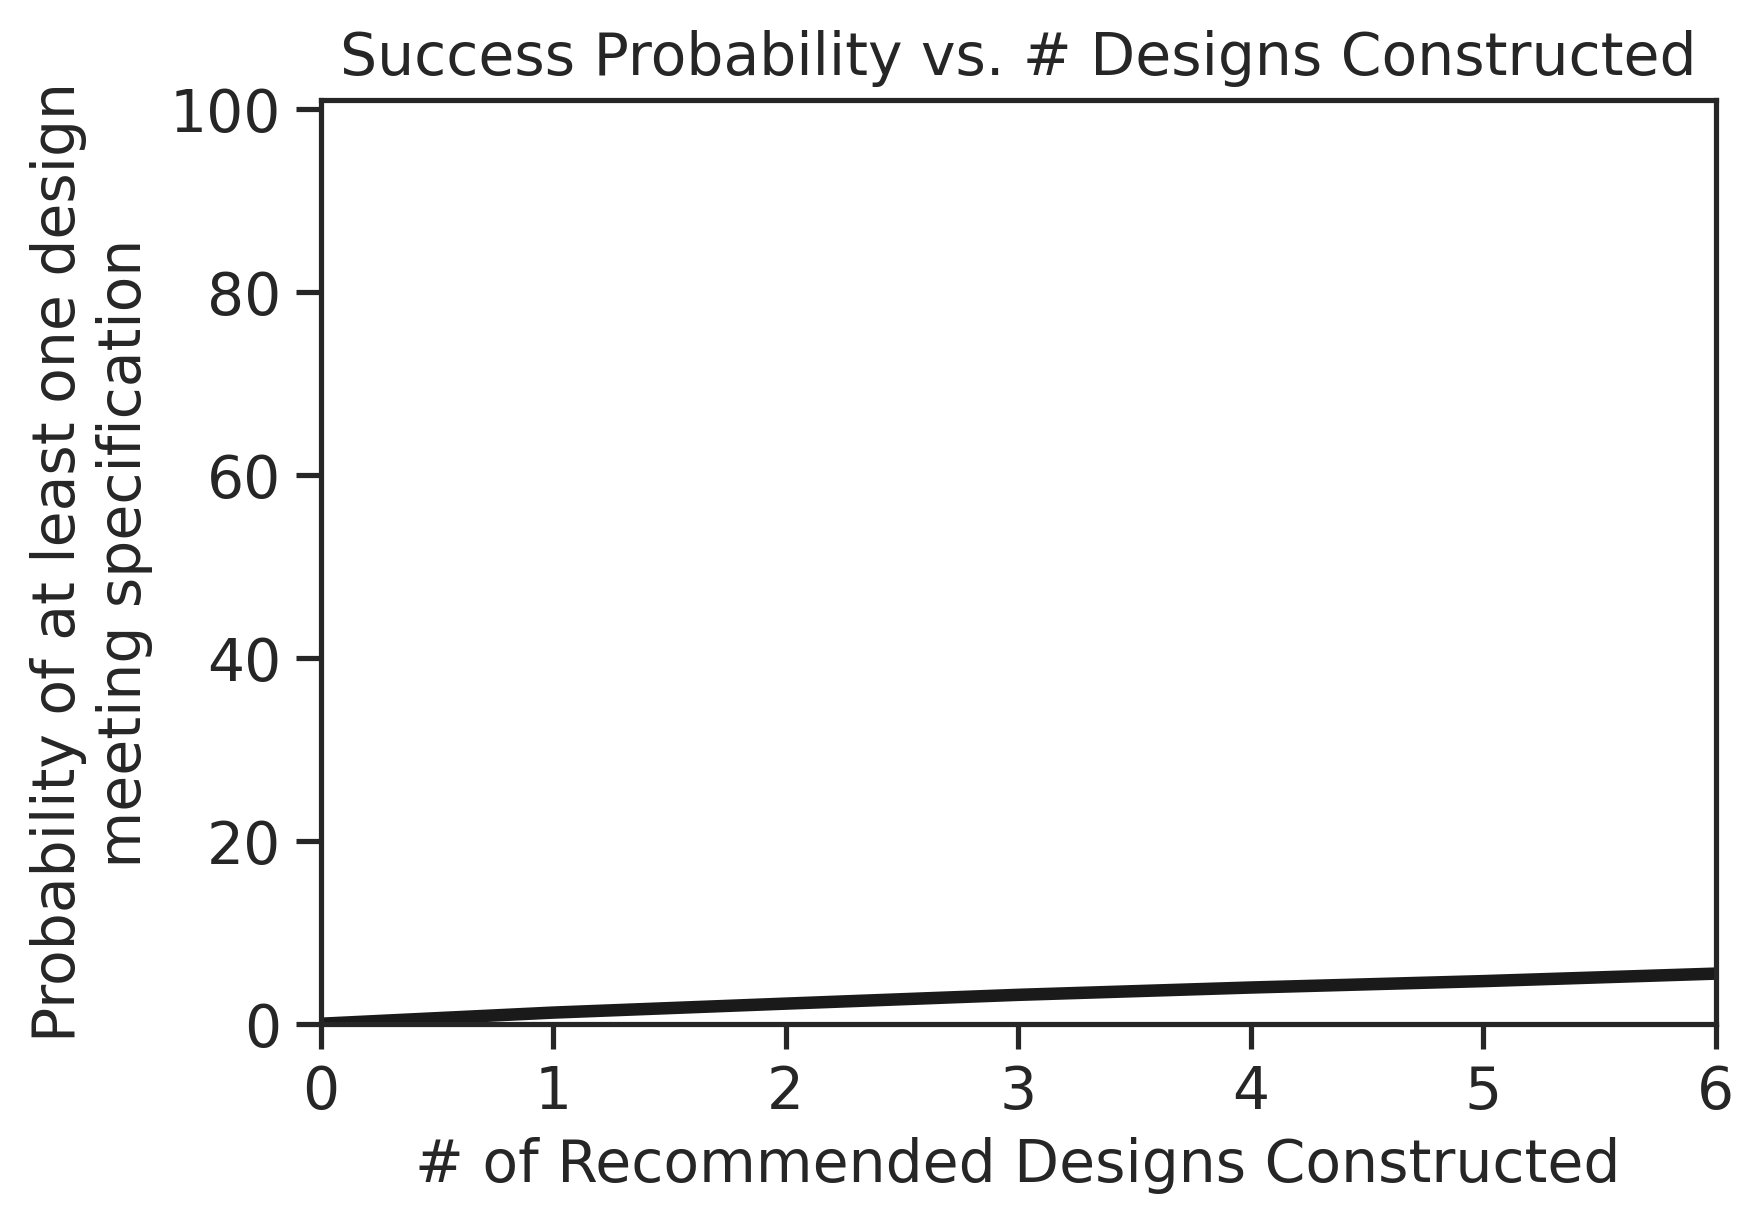

CPU times: user 11min 45s, sys: 9.55 s, total: 11min 55s
Wall time: 16min 14s


In [161]:
%%time
art = RecommendationEngine(df=df, alpha = 0, **art_params)

### alpha = 1.0

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 24 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(ZeroCount(input_matrix), learning_rate=1.0, max_depth=3, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 41.88 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 26.15 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(CombineDFs(ZeroCount(ZeroCount(PolynomialFeatures(ZeroCount(input_matrix), degree=2, include_bias=False, interaction_only=False))), input_matrix))
Done fitting L0 models in 24.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 24.53 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(ZeroCount(MinMaxScaler(StandardScaler(input_matrix))), l1_ratio=0.05, tol=0.01)
Done fitting L0 models in 36.18 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 21.75 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(Normalizer(input_matrix, norm=l2))
Done fitting L0 models in 62.66 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 32.18 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(OneHotEncoder(RobustScaler(ZeroCount(input_matrix)), minimum_fraction=0.1, sparse=False, threshold=10), l1_ratio=0.1, tol=0.0001)
Done fitting L0 models in 35.31 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.34 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)
Done fitting L0 models in 45.74 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.36 s
Fitting L0 models…
Building TPOT models…
Best pipeline: GradientBoostingRegressor(Normalizer(input_matrix, norm=l2), alpha=0.75, learning_rate=0.1, loss=huber, max_depth=9, max_features=0.5, min_samples_leaf=2, min_samples_split=8, n_estimators=100, subsample=0.7000000000000001)
Done fitting L0 models in 60.45 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 21.22 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(ZeroCount(input_matrix)), learning_rate=0.5, loss=square, n_estimators=100)
Done fitting L0 models in 58.73 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 21.60 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(ZeroCount(Normalizer(input_matrix, norm=l2)), l1_ratio=0.30000000000000004, tol=1e-05)
Done fitting L0 models in 33.93 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.48 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(Normalizer(input_matrix, norm=max), normalize=True)
Done fitting L0 models in 29.24 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 30.42 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(ZeroCount(AdaBoostRegressor(RidgeCV(input_matrix), learning_rate=0.5, loss=linear, n_estimators=100)))
Done fitting L0 models in 44.42 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 30.48 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(PolynomialFeatures(RidgeCV(Normalizer(input_matrix, norm=l2)), degree=2, include_bias=False, interaction_only=False), normalize=False)
Done fitting L0 models in 51.41 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 28.46 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.143371,28.961285,0.114686,0.033708,-1.005274
Random Forest Regressor,0.054006,12.661817,0.053756,0.005806,0.654581
Support Vector Regressor,0.090804,19.395861,0.037419,0.009646,0.426192
Kernel Ridge Regressor,0.150670,30.276432,0.114023,0.035703,-1.123915
K-NN Regressor,0.072122,18.090565,0.067793,0.009797,0.417162
Gaussian Process Regressor,0.059127,14.451447,0.057884,0.006847,0.592704
Gradient Boosting Regressor,0.060490,13.964770,0.063744,0.007722,0.540601
TPOT Regressor,0.053385,11.813948,0.051391,0.005491,0.673345
Ensemble Model,0.056204,12.585034,0.037622,0.004574,0.727883


Done with 12-fold cross-validation in 844.32 s


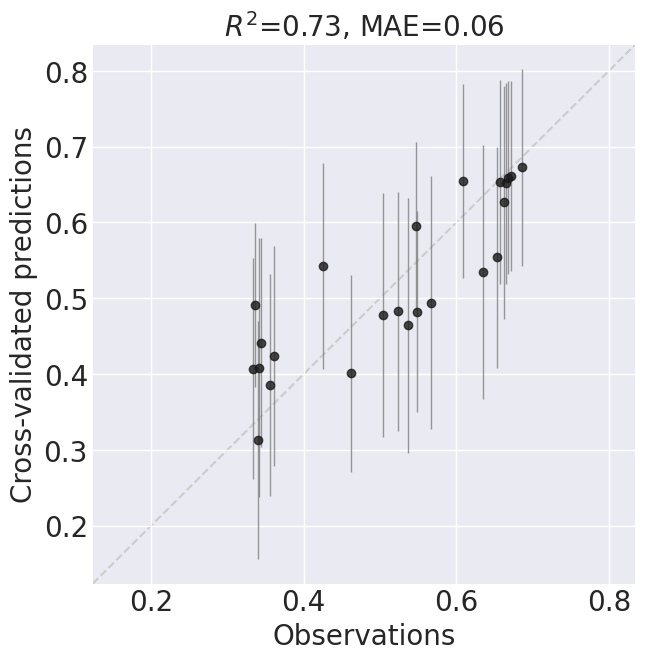

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(RobustScaler(StandardScaler(ZeroCount(input_matrix))))
Done fitting L0 models in 39.57 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 22.87 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.877133e-02,19.260228,6.179803e-02,1.169935e-02,0.304017
Random Forest Regressor,1.893241e-02,4.361924,1.950699e-02,7.389585e-04,0.956040
Support Vector Regressor,8.116291e-02,17.035157,2.832903e-02,7.389953e-03,0.560379
Kernel Ridge Regressor,5.967892e-02,11.658325,4.133604e-02,5.270242e-03,0.686478
K-NN Regressor,5.840030e-02,14.259077,5.413514e-02,6.341208e-03,0.622768
Gaussian Process Regressor,7.138594e-09,0.000001,7.997260e-09,1.149157e-16,1.000000
Gradient Boosting Regressor,3.735910e-04,0.065840,4.051146e-04,3.036880e-07,0.999982
TPOT Regressor,2.859726e-02,6.299410,1.950752e-02,1.198347e-03,0.928711
Ensemble Model,1.921158e-02,4.137260,1.006125e-02,4.703134e-04,0.972022


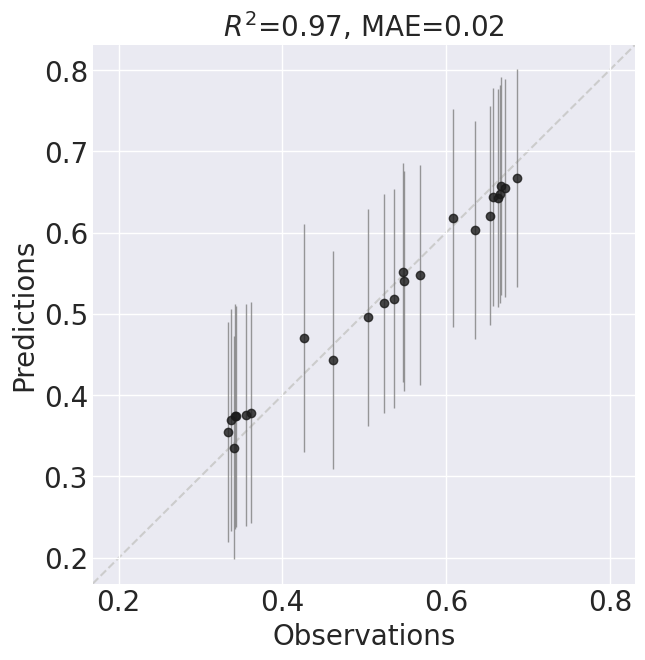

Done building models in 63.85 s
Finding all possible categorical designs…
Done finding categorical designs in 95.27 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.01 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,1.0,0.425429
1,2.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,0.425954
2,2.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.353886
3,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,0.462874
4,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.352387
5,2.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.433628


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.87 s


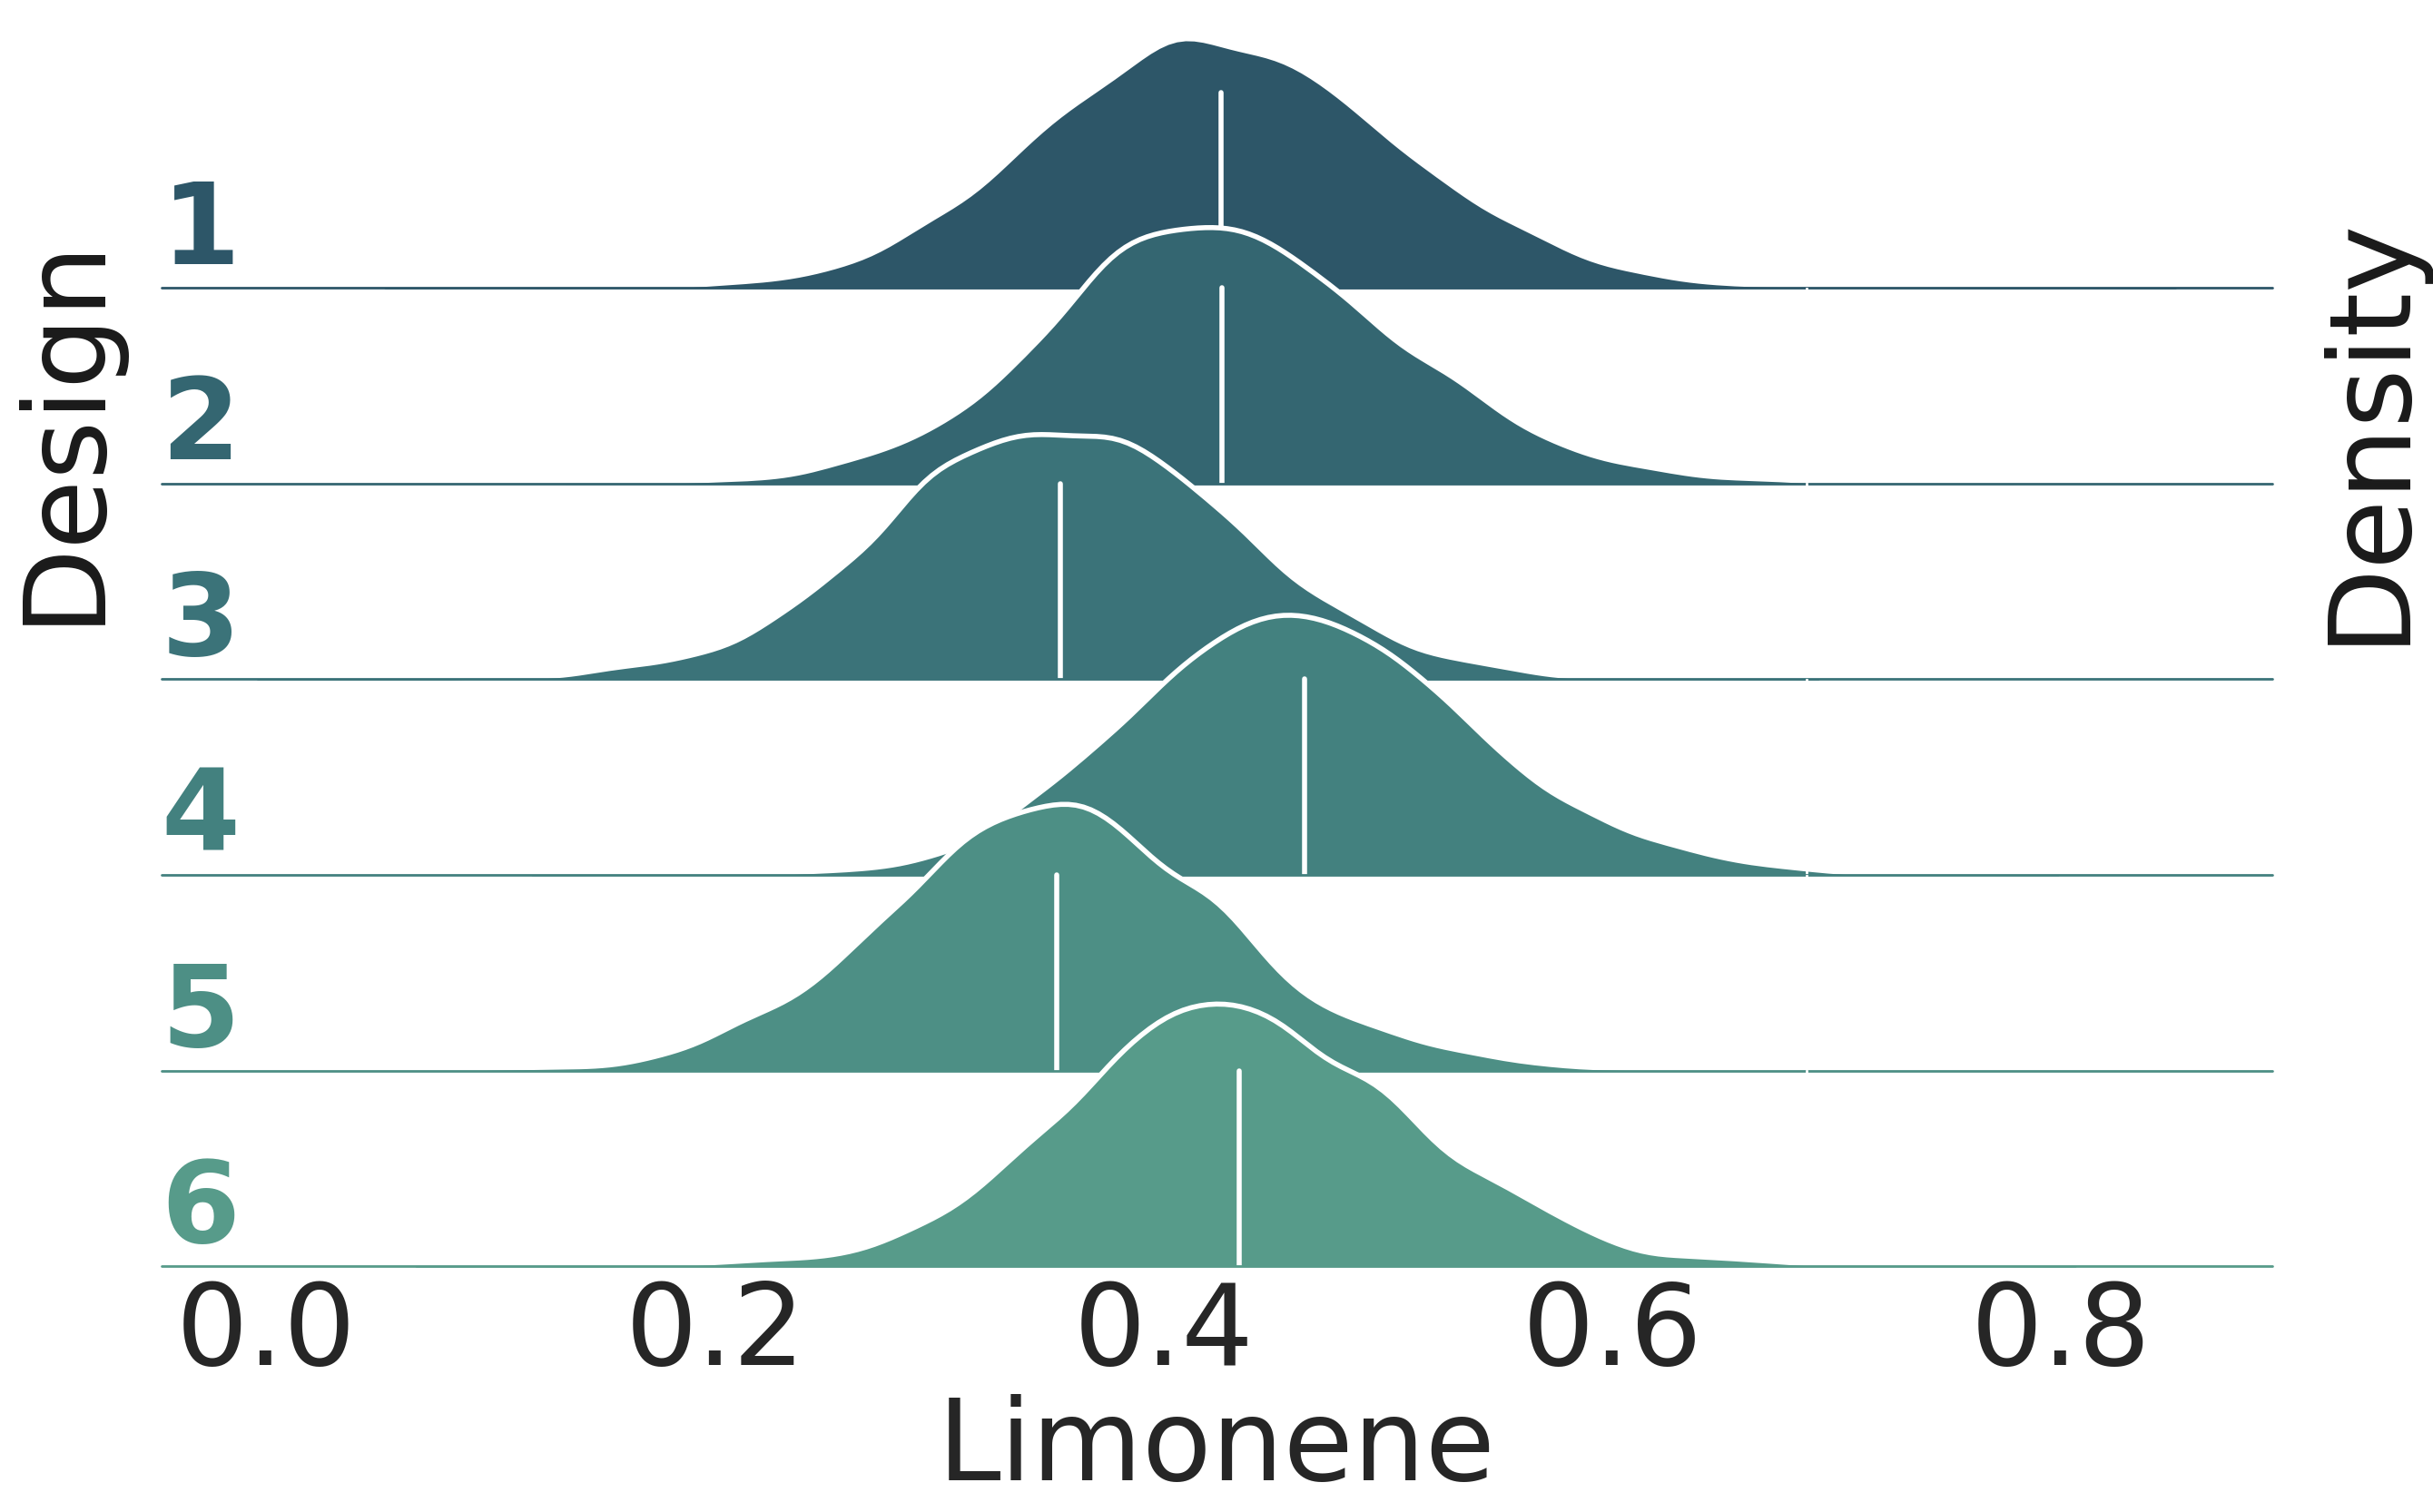

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.89 s
Done computing success probabilities in 0.89 s


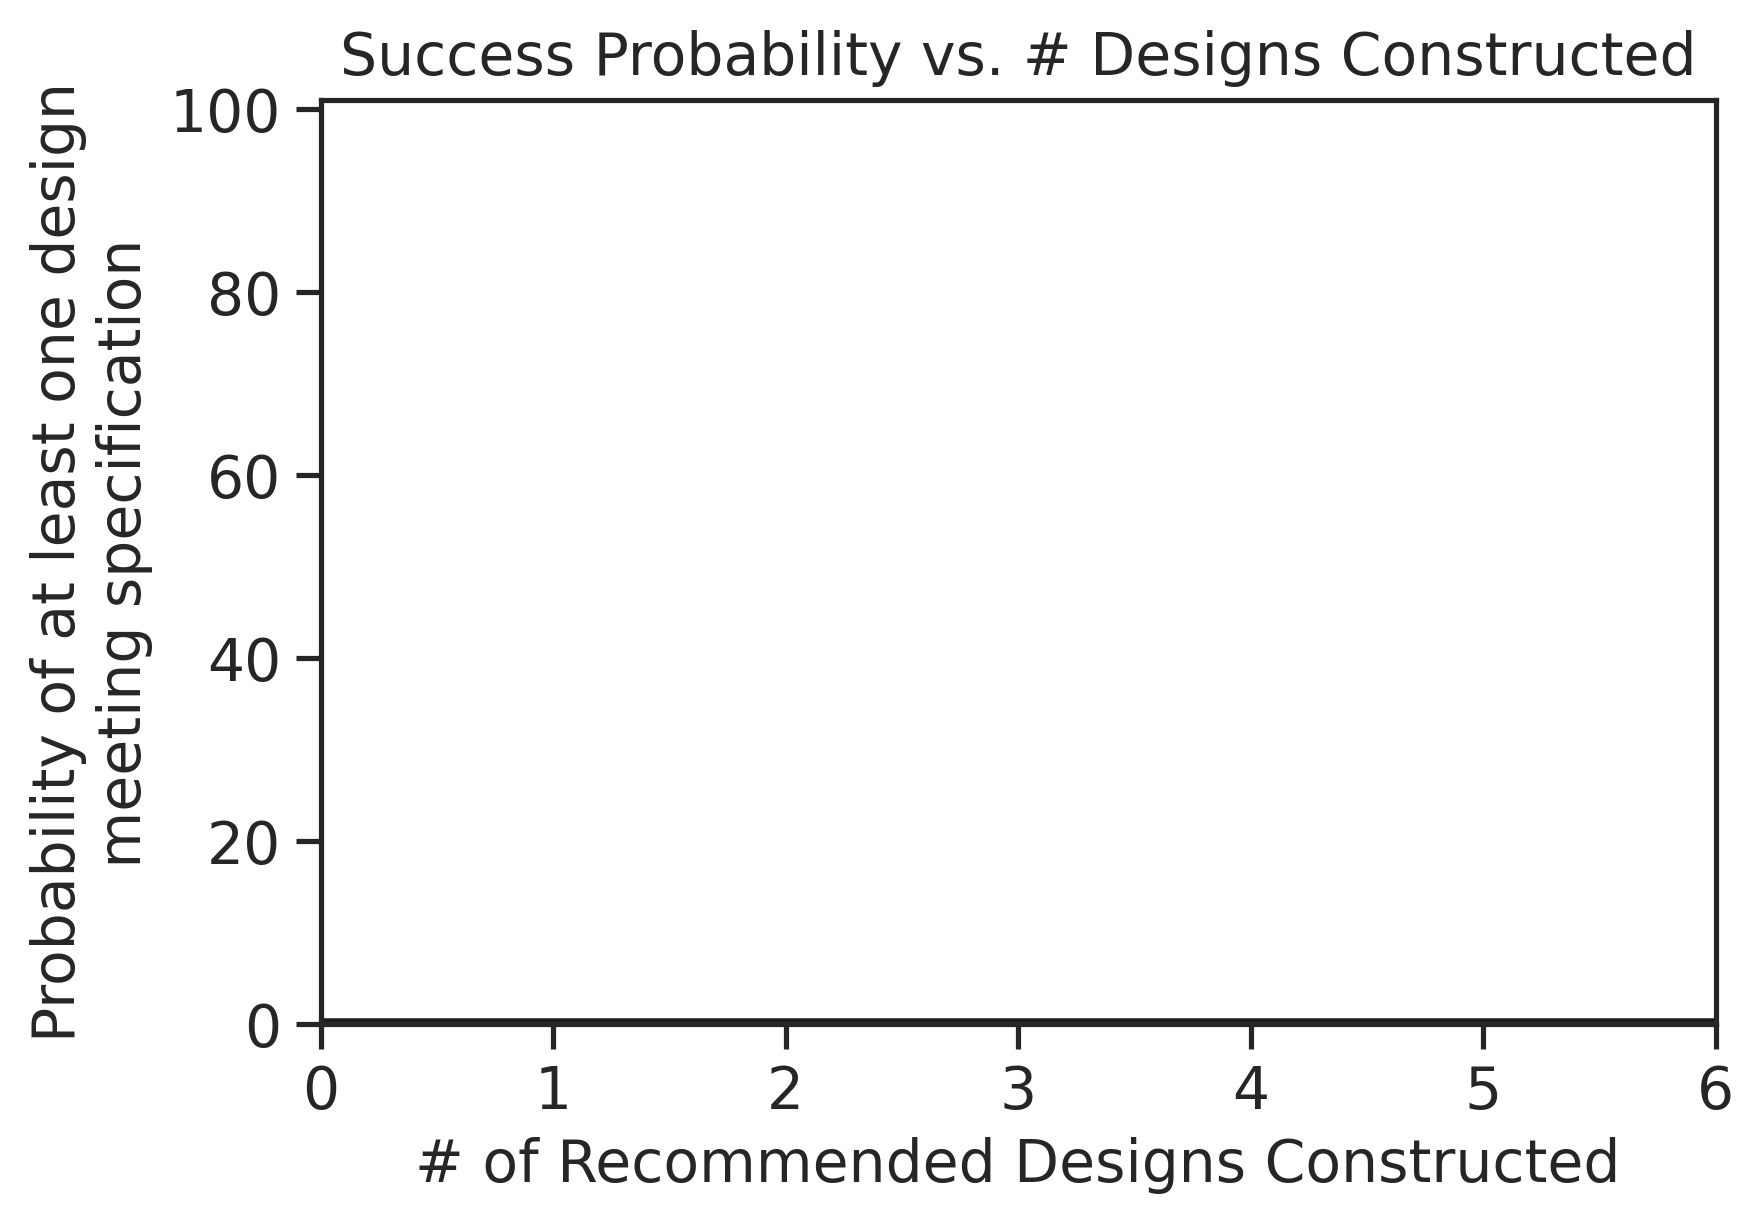

CPU times: user 12min 6s, sys: 10.1 s, total: 12min 17s
Wall time: 16min 48s


In [162]:
%%time
art = RecommendationEngine(df=df, alpha = 1, **art_params)

# Phase 3: Results

## Predictions VS Observations

In [5]:
predob = pd.read_csv("../data/PredVSOb.csv")

In [6]:
predob

,C2pred,C2obs,C1pred,C1obs
0,0.631515,0.667200,0.549435,0.665311
1,0.626830,0.686426,0.548289,0.657144
2,0.625690,0.671710,0.545586,0.608984
3,0.451594,0.355708,0.441341,0.634736
4,0.457713,0.342061,0.459868,0.547529
5,0.473731,0.524138,0.460737,0.653362


In [7]:
Ori = pd.read_csv("../data/Original_Ob.csv")

In [8]:
Ori

,Limonene
0,0.548045
1,0.425960
2,0.340830
3,0.333494
4,0.567516
5,0.343577
6,0.461772
7,0.662760
8,0.504226
9,0.536793


In [9]:
WT = 0.548045

### Cycle 1 Recommendations

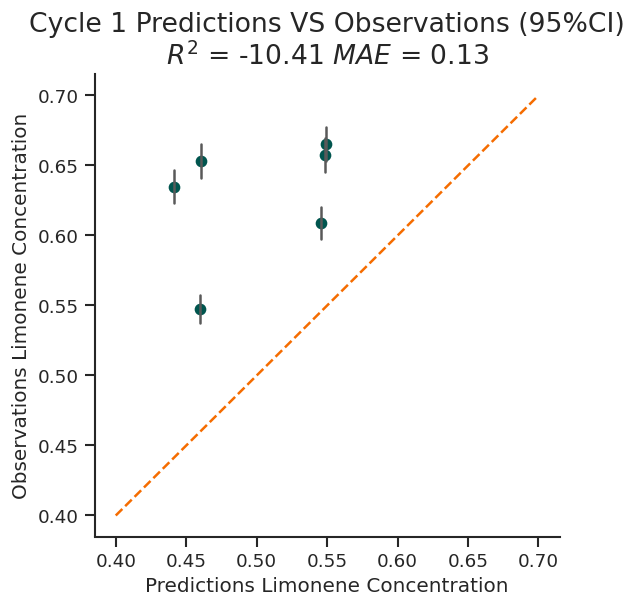

In [92]:
"""
Every single observation is the average of triplicate experiment, the error bar is 
calculated by the triplicate samples' variance.

R square is calculated by comparing the predictions with the observations.


"""

sns.set_theme(style="ticks")

plt.figure(figsize=(5,5),dpi=120)

r2 = r2_score(predob['C1obs'], predob['C1pred'])

df1 = pd.read_csv("../data/Cycle 1/17rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")
df2 = pd.read_csv("../data/Cycle 1/18rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")
df3 = pd.read_csv("../data/Cycle 1/19rep_75noiseLevel_6recommend_cycle_1_weiyu_7strains_METABOLITE.csv")

df1 = df1[df1['Time/hours'] == 24.0]['Limonene']
df2 = df2[df2['Time/hours'] == 24.0]['Limonene']
df3 = df3[df3['Time/hours'] == 24.0]['Limonene']

var = pd.concat([df1, df2, df3], axis = 1).T.var().iloc[1:]

errors = np.sqrt(var)

sample_size = 3
critical_value = 1.96

standard_errors = errors / np.sqrt(sample_size)
standard_errors.index = np.linspace(0,5,6)

conf_interval_lower = predob['C1obs'] - critical_value * standard_errors
conf_interval_upper = predob['C1obs'] + critical_value * standard_errors

for xi, lower, upper in zip(predob['C1pred'], conf_interval_lower, conf_interval_upper):
    plt.plot([xi, xi], [lower, upper], color='#595959', linestyle = '-')
    
plt.scatter(predob['C1pred'], predob['C1obs'], marker = 'o', color = '#00554e')
plt.plot([0.4,0.7],[0.4,0.7],color = '#f56c00', linestyle = '--')

mae = np.mean(np.abs(predob['C1pred'] - predob['C1obs']))

sns.despine()

plt.xlabel("Predictions Limonene Concentration", fontsize=12)
plt.ylabel("Observations Limonene Concentration", fontsize=12)
plt.title("Cycle 1 Predictions VS Observations (95%CI)\n"+
          "$R^2$ = "+str(f"{r2:.2f}")+"  $MAE$ = "+str(f"{mae:.2f}"), fontsize=16)
plt.grid(False)

plt.show()

### Cycle 2 Recommendations

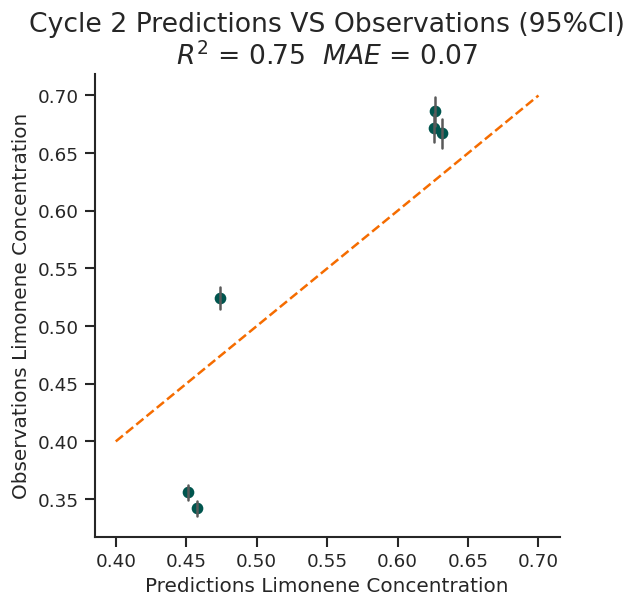

In [93]:
sns.set_theme(style="ticks")

plt.figure(figsize=(5,5),dpi=120)

r2 = r2_score(predob['C2obs'], predob['C2pred'])

df1 = pd.read_csv("../data/Cycle 2/17rep_75noiseLevel_6recommend_cycle_2_weiyu_7strains_METABOLITE.csv.csv")
df2 = pd.read_csv("../data/Cycle 2/18rep_75noiseLevel_6recommend_cycle_2_weiyu_7strains_METABOLITE.csv.csv")
df3 = pd.read_csv("../data/Cycle 2/19rep_75noiseLevel_6recommend_cycle_2_weiyu_7strains_METABOLITE.csv.csv")

df1 = df1[df1['Time/hours'] == 24.0]['Limonene']
df2 = df2[df2['Time/hours'] == 24.0]['Limonene']
df3 = df3[df3['Time/hours'] == 24.0]['Limonene']

var = pd.concat([df1, df2, df3], axis = 1).T.var().iloc[1:]

errors = np.sqrt(var)

sample_size = 3
critical_value = 1.96

standard_errors = errors / np.sqrt(sample_size)
standard_errors.index = np.linspace(0,5,6)

conf_interval_lower = predob['C2obs'] - critical_value * standard_errors
conf_interval_upper = predob['C2obs'] + critical_value * standard_errors

for xi, lower, upper in zip(predob['C2pred'], conf_interval_lower, conf_interval_upper):
    plt.plot([xi, xi], [lower, upper], color='#595959', linestyle = '-')
    
plt.scatter(predob['C2pred'], predob['C2obs'], marker = 'o', color = '#00554e')
plt.plot([0.4,0.7],[0.4,0.7],color = '#f56c00', linestyle = '--')

mae = np.mean(np.abs(predob['C2pred'] - predob['C2obs']))

sns.despine()

plt.xlabel("Predictions Limonene Concentration", fontsize=12)
plt.ylabel("Observations Limonene Concentration", fontsize=12)
plt.title("Cycle 2 Predictions VS Observations (95%CI)\n"+
          "$R^2$ = "+str(f"{r2:.2f}")+"  $MAE$ = "+str(f"{mae:.2f}"), fontsize=16)
plt.grid(False)

plt.show()

### Different Cycle Comparision

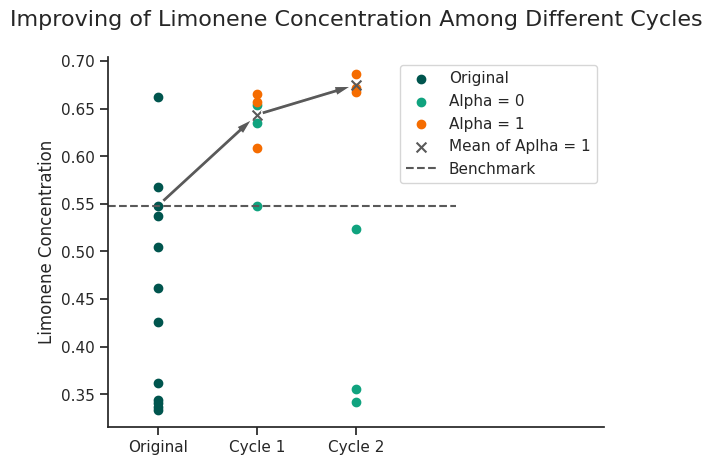

In [90]:
import matplotlib.pyplot as plt
import numpy as np


epoch1 = Ori  
epoch2_alpha1 = predob['C1obs'].iloc[:3]
epoch2_alpha0 = predob['C1obs'].iloc[3:]
epoch3_alpha1 = predob['C2obs'].iloc[:3] 
epoch3_alpha0 = predob['C2obs'].iloc[3:] 

e2_m = epoch2_alpha1.mean()
e3_m = epoch3_alpha1.mean()

x1 = np.ones(epoch1.shape) * 0.2
x2_1 = np.ones(epoch2_alpha1.shape) * 0.4 
x2_2 = np.ones(epoch2_alpha0.shape) * 0.4 
x3_1 = np.ones(epoch3_alpha1.shape) * 0.6
x3_2 = np.ones(epoch3_alpha0.shape) * 0.6 

plt.scatter(x1, epoch1, label='Original', color = '#00554e')
plt.scatter(x2_2, epoch2_alpha0, label='Alpha = 0', color = '#10a37f')
plt.scatter(x2_1, epoch2_alpha1, label='Alpha = 1', color = '#f56c00')
plt.scatter(x3_1, epoch3_alpha1, color = '#f56c00')
plt.scatter(x3_2, epoch3_alpha0, color = '#10a37f')

plt.scatter(0.4, e2_m, marker = 'x', color = '#595959', s = 50, label = 'Mean of Aplha = 1')
plt.scatter(0.6, e3_m, marker = 'x', color = '#595959', s = 50)

#plt.plot([])

plt.annotate('', xy=(0.4, e2_m), xytext=(0.2, 0.548045),
             arrowprops=dict(facecolor='#595959', shrink=0.05, width=3, headwidth=7))
plt.annotate('', xy=(0.6, e3_m), xytext=(0.4, e2_m),
             arrowprops=dict(facecolor='#595959', shrink=0.05, width=3, headwidth=7))

plt.axhline(xmax = 0.7, y = 0.548045, color = '#595959', linestyle = '--', label = 'Benchmark')

plt.xticks([0.2, 0.4, 0.6], ['Original', 'Cycle 1', 'Cycle 2'])

plt.ylabel('Limonene Concentration')
plt.xlim([0.1,1.1])
plt.title('Improving of Limonene Concentration Among Different Cycles\n', fontsize = 16)

sns.despine()

plt.legend()

plt.show()